In [28]:
import os
import sys
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import config
os.chdir(config.LOOP_CATALOG_DIR)
sns.set_theme(style="whitegrid")
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('max_colwidth', 400)

## Apply QC Flags - FH Loops

In [154]:
org = "mm10"
organism = "Mouse"
merge = "merged"

date1 = "10.16.2024"
date2 = "10_16_24"

#### Prepare Pre-Processing Stats

In [155]:
hicpro_all = pd.read_csv("results/tables/update_{d1}/tsv/{o}.{m}_hicpro.{d2}.tsv".format(o = org, m = merge, d1 = date1, d2 = date2), sep = "\t")
if merge == "merged" and org == "hg38":
    hicpro_all = pd.concat([hicpro_all, pd.read_csv("results/tables/update_{d1}/tsv/hg38.mega-merged_hicpro.{d2}.tsv".format(d1 = date1, d2 = date2), sep = "\t")])

In [156]:
hicpro_all["mean_mapping_percentage"] = hicpro_all.apply(lambda x : np.mean([x["mapped_R1"] / x["total_R1"], x["mapped_R2"] / x["total_R2"]]), axis = 1)
hicpro_all["percent_validpairs"] = hicpro_all.apply(lambda x : x["Valid_interaction_pairs"] / x["Reported_pairs"], axis = 1)
#hicpro_all["percent_invalid_pairs"] = hicpro_all.apply(lambda x : (x["Dangling_end_pairs"] + x["Religation_pairs"] + x["Self_Cycle_pairs"] + x["Single-end_pairs"] + x["Filtered_pairs"] + x["Dumped_pairs"]) / x["Reported_pairs"], axis = 1)
hicpro_all["percent_duplicate"] = hicpro_all.apply(lambda x : 1 - (x["valid_interaction_rmdup"] / x["valid_interaction"]), axis = 1)
#hicpro_all["cis_trans_ratio"] = hicpro_all.apply(lambda x : x["cis_interaction"] / x["trans_interaction"], axis = 1)
hicpro_all["percent_cis"] = hicpro_all.apply(lambda x : x["cis_interaction"] / (x["trans_interaction"] + x["cis_interaction"]), axis = 1)
hicpro_all["precent_cis_long_range"] = hicpro_all.apply(lambda x : x["cis_longRange"] / x["cis_interaction"], axis = 1)

In [157]:
hicpro_all = hicpro_all[["std_sample_name", "Total_pairs_processed", "valid_interaction_rmdup", "mean_mapping_percentage", "percent_validpairs", "percent_duplicate", "percent_cis", "precent_cis_long_range"]]
hicpro_all.columns = ["Sample Name", "num_reads", "num_vp", "mean_mapping_percentage", "percent_validpairs", "percent_duplicate", "percent_cis", "precent_cis_long_range"]

In [158]:
len(hicpro_all)

109

#### Prepare Peaks and Loops Stats

In [159]:
l = pd.read_csv("results/tables/update_{d1}/tsv/{o}.{m}_loops.fithichip.{d2}.tsv".format(o = org, m = merge, d1 = date1, d2 = date2), sep = "\t")
p = pd.read_csv("results/tables/update_{d1}/tsv/{o}.{m}_peaks.fithichip.{d2}.tsv".format(o = org, m = merge, d1 = date1, d2 = date2), sep = "\t")

if merge == "merged" and org == "hg38":
    l = pd.concat([l, pd.read_csv("results/tables/update_{d1}/tsv/hg38.mega-merged_loops.fithichip.{d2}.tsv".format(o = org, m = merge, d1 = date1, d2 = date2), sep = "\t")])
    p = pd.concat([p, pd.read_csv("results/tables/update_{d1}/tsv/hg38.mega-merged_peaks.fithichip.{d2}.tsv".format(o = org, m = merge, d1 = date1, d2 = date2), sep = "\t")])
    
l.columns = ["Sample Name", "Peaks", "Stringent 5kb", "Loose 5kb", "Stringent 10kb", "Loose 10kb", "Stringent 25kb", "Loose 25kb"]
p.columns = ["Sample Name", "Number of Peaks", "Average Peak Size (bp)"]

In [160]:
print(len(l))
print(len(p))

109
109


#### Merge All Stats Together

In [161]:
f = hicpro_all.merge(p, on = "Sample Name")
f = f.merge(l, on = "Sample Name").drop(columns = ["Average Peak Size (bp)"])

In [162]:
len(f)

109

#### General Helper Functions

In [163]:
def calculate_upper_bounds(f, stats):
    upper_bounds = []
    for stat in stats:
        if max(list(f[stat])) <= 1:
            upper_bounds.append(1)
        else:
            data = np.array(f[stat])
            iqr = np.subtract(*np.percentile(data, [75, 25]))
            upper_bounds.append(np.percentile(data, 75) + (1.5 * iqr))
    return upper_bounds

def calculate_weights(t1, t2, i1, i2, i3, i4, upper_bound):
    weights = {"Poor" : (i2 - i1) / t1, 
               "Warning" : (i3 - i2) / (t2 - t1), 
               "Good" : (i4 - i3) / (upper_bound - t2)}   
    return weights
      
def calculate_score(stat, t1, t2, i1, i2, i3, i4, upper_bound):
    weights = calculate_weights(t1, t2, i1, i2, i3, i4, upper_bound)
    if stat < t1:
        return weights["Poor"] * stat
    elif stat >= t1 and stat < t2:
        return weights["Warning"] * (stat - t1) + i2
    else:
        if stat > upper_bound:
            return 10
        return weights["Good"] * (stat - t2) + i3

In [164]:
def qc_score(stats, intervals, upper_bounds, feature):    
    if feature == "preprocess":
        thres = {"num_reads" : (30000000, 50000000), 
                 "num_vp" : (3000000, 10000000), 
                 "prop_mapping" : (0.70, 0.80), 
                 "prop_vp" : (0.40, 0.60), 
                 "prop_dup" : (0.85, 0.50), 
                 "prop_cis" : (0.40, 0.60), 
                 "prop_cis_lr" : (0.30, 0.40)}
    elif feature == "peaks":
        thres = {"num_peaks" : (1000, 5000)}
    elif feature == "loops":
        thres = {"num_loops_s5" : (100, 1000),
                 "num_loops_l5" : (100, 1000),
                 "num_loops_s10" : (100, 1000),
                 "num_loops_l10" : (100, 1000),
                 "num_loops_s25" : (100, 1000),
                 "num_loops_l25" : (100, 1000)}
    
    scores = [None] * len(stats)

    for i in range(0, len(stats)):
        if feature == "loops":
            if i % 2 == 0: # 0, 2, 4 (stringent)
                if stats[i] > stats[i+1]:
                    scores[i] = 0
                    continue
            else: # 1, 3, 5 (loose)
                if stats[i-1] > stats[i]:
                    scores[i] = 0
                    continue
                    
        thres1 = thres[list(thres.keys())[i]][0]
        thres2 = thres[list(thres.keys())[i]][1]
        
        if thres1 < thres2:
            scores[i] = calculate_score(stats[i], thres1, thres2, intervals[0], intervals[1], intervals[2], intervals[3], upper_bounds[i])
        else:
            scores[i] = intervals[3] - calculate_score(stats[i], thres1, thres2, intervals[0], intervals[1], intervals[2], intervals[3], upper_bounds[i]) 
    return pd.Series(scores)

def qc_flag(scores, intervals):
    scores = np.array(scores)
    quadratic = False
    if quadratic:
        scores = scores ** 2
        score_agg = sum(scores) / len(scores)
        if score_agg < (intervals[1] * intervals[3]):
            flag = "Poor"
        elif score_agg >= (intervals[1] * intervals[3]) and score_agg < (intervals[2] * intervals[3]):
            flag = "Warning"
        else:
            flag = "Good"
    else:
        score_agg = np.mean(scores)
        if score_agg < (intervals[1]):
            flag = "Poor"
        elif score_agg >= (intervals[1]) and score_agg < (intervals[2]):
            flag = "Warning"
        else:
            flag = "Good"
    return pd.Series((score_agg, flag))

def final_flag(flag1, flag2):
    if flag1 == "Poor" and flag2 == "Poor":
        return "Poor"
    elif flag1 == "Warning" and flag2 == "Poor":
        return "Poor"
    elif flag1 == "Good" and flag2 == "Poor":
        return "Poor"
    elif flag1 == "Poor" and flag2 == "Warning":
        return "Poor"
    elif flag1 == "Warning" and flag2 == "Warning":
        return "Warning"
    elif flag1 == "Good" and flag2 == "Warning":
        return "Warning"
    elif flag1 == "Poor" and flag2 == "Good":
        return "Poor"
    elif flag1 == "Warning" and flag2 == "Good":
        return "Warning"
    elif flag1 == "Good" and flag2 == "Good":
        return "Good"  

#### General Variables

In [165]:
intervals = [0, 6, 8, 10]

#### Apply Flags - Pre-Processing

In [166]:
upper_bounds = calculate_upper_bounds(f, ["num_reads", "num_vp", "mean_mapping_percentage", "percent_validpairs", "percent_duplicate", "percent_cis", "precent_cis_long_range"])
upper_bounds

[1261549328.5, 335449508.0, 1, 1, 1, 1, 1]

In [167]:
f[["score_num_reads", "score_num_vp", "score_prop_mapping", "score_prop_vp", "score_prop_dups", "score_prop_cis", "score_prop_cislr"]] = f.apply(lambda x : qc_score([x["num_reads"], x["num_vp"], x["mean_mapping_percentage"], x["percent_validpairs"], x["percent_duplicate"], x["percent_cis"], x["precent_cis_long_range"]], intervals, upper_bounds, "preprocess"), axis = 1)
f[["PREPROCESSING_SCORE", "PREPROCESSING_FLAG"]] = f.apply(lambda x : qc_flag([x["score_num_reads"], x["score_num_vp"],x["score_prop_mapping"], x["score_prop_vp"], x["score_prop_dups"], x["score_prop_cis"], x["score_prop_cislr"]], intervals), axis = 1)

In [168]:
f.describe()

num_reads        num_vp  mean_mapping_percentage  \
count  1.090000e+02  1.090000e+02               109.000000   
mean   4.711621e+08  1.338921e+08                 0.905158   
std    2.669196e+08  1.090877e+08                 0.083772   
min    4.819070e+07  4.135591e+06                 0.502427   
25%    2.544029e+08  6.750439e+07                 0.903093   
50%    4.321481e+08  9.442243e+07                 0.938023   
75%    6.572615e+08  1.746824e+08                 0.951676   
max    1.171548e+09  5.043628e+08                 0.968206   

       percent_validpairs  percent_duplicate  percent_cis  \
count          109.000000         109.000000   109.000000   
mean             0.769273           0.310970     0.787821   
std              0.210399           0.229226     0.102852   
min              0.037506           0.022806     0.447275   
25%              0.652628           0.113303     0.744703   
50%              0.845388           0.274073     0.811995   
75%              0.912117           0.441208     0.863522   
max              0.997676           0.913175     0.946181   

       precent_cis_long_range  Number of Peaks          Peaks  Stringent 5kb  \
count              109.000000       109.000000     109.000000     109.000000   
mean                 0.706754     39631.036697   39631.036697   15182.587156   
std                  0.169815     49533.776605   49533.776605   38666.861602   
min                  0.093924         0.000000       0.000000       0.000000   
25%                  0.648766      8344.000000    8344.000000     201.000000   
50%                  0.751730     26657.000000   26657.000000    2064.000000   
75%                  0.816445     45381.000000   45381.000000    7820.000000   
max                  0.912941    253915.000000  253915.000000  235223.000000   

           Loose 5kb  Stringent 10kb     Loose 10kb  Stringent 25kb  \
count     109.000000      109.000000     109.000000      109.000000   
mean    65817.036697    25808.211009   91902.990826    46190.458716   
std    149769.304965    48070.433843  153661.306525    57208.718296   
min         0.000000        0.000000       0.000000        0.000000   
25%       613.000000     1047.000000    3915.000000     5712.000000   
50%     10601.000000     9136.000000   36680.000000    23889.000000   
75%     43684.000000    24419.000000  100234.000000    62824.000000   
max    810919.000000   287295.000000  822131.000000   272261.000000   

          Loose 25kb  score_num_reads  score_num_vp  score_prop_mapping  \
count     109.000000       109.000000    109.000000          109.000000   
mean   119277.761468         8.692487      8.673164            9.001095   
std    130208.219090         0.445489      0.698641            0.994129   
min         0.000000         7.819070      6.324455            4.306516   
25%     17446.000000         8.337424      8.353384            9.030926   
50%     79237.000000         8.630842      8.518805            9.380227   
75%    173516.000000         9.002454      9.012031            9.516756   
max    617510.000000         9.851427     10.000000            9.682059   

       score_prop_vp  score_prop_dups  score_prop_cis  score_prop_cislr  \
count     109.000000       109.000000      109.000000        109.000000   
mean        8.598987         7.745284        8.913218          8.804805   
std         1.846585         1.819258        0.597914          1.371621   
min         0.562584         0.347300        6.472751          1.878473   
25%         8.263141         6.885589        8.723515          8.829221   
50%         9.226938         8.065365        9.059974          9.172433   
75%         9.560583         9.200215        9.317610          9.388150   
max         9.988382         9.839019        9.730907          9.709803   

       PREPROCESSING_SCORE  
count           109.000000  
mean              8.632720  
std               0.609882  
min               6.282797  
25%               8.355348  
50%           

In [169]:
f["PREPROCESSING_FLAG"].value_counts()

PREPROCESSING_FLAG
Good       99
Warning    10
Name: count, dtype: int64

In [170]:
sns.set_theme(style="ticks")

columns_pairs = [
    ("num_reads", "score_num_reads"),
    ("num_vp", "score_num_vp"),
    ("mean_mapping_percentage", "score_prop_mapping"),
    ("percent_validpairs", "score_prop_vp"),
    ("percent_duplicate", "score_prop_dups"),
    ("percent_cis", "score_prop_cis"),
    ("precent_cis_long_range", "score_prop_cislr")
]

column_labels = [
    ("Number of Reads", "Number of Reads Score"),
    ("Number of Valid Pairs", "Number of Valid Pairs Score"),
    ("Mean Mapping % (R1/R2)", "Mean Mapping % (R1/R2) Score"),
    ("% Valid Pairs", "% Valid Pairs Score"),
    ("% Duplicate Pairs", "% Duplicate Pairs Score"),
    ("% Cis Pairs", "% Cis Pairs Score"),
    ("% Cis Long-Range Pairs", "% Cis Long-Range Pairs Score")
]

fill_values = [
    [(0, 30000000), (30000000, 50000000), (50000000, max(list(f["num_reads"])))],
    [(0, 3000000), (3000000, 10000000), (10000000, max(list(f["num_vp"])))],
    [(0, 0.70), (0.70, 0.80), (0.80, 1)],
    [(0, 0.40), (0.40, 0.60), (0.60, 1)],
    [(0.85, 1), (0.45, 0.85), (0.0, 0.45)],
    [(0, 0.40), (0.40, 0.60), (0.60, 1)],
    [(0, 0.30), (0.30, 0.40), (0.40, 1)],
]

fig, axes = plt.subplots(nrows=len(columns_pairs), ncols=2, figsize=(10.0, 15.0 / 7.0 * len(columns_pairs)))

for i, (col1, col2) in enumerate(columns_pairs):
    sns.histplot(f[col1], alpha=0.4, bins=30, element="step", color="gray", ax=axes[i, 0])
    y1_max = axes[i, 0].get_ylim()[1]
    
    sns.histplot(np.array(f[col2]), alpha=0.4, color="chocolate", bins=30, element="step", ax=axes[i, 1])
    y2_max = axes[i, 1].get_ylim()[1]

    y_max = max(y1_max, y2_max) * 1.02
    
    fill = fill_values[i]
    axes[i, 0].fill_betweenx(y=[0, y_max], x1=fill[0][0], x2=fill[0][1], color='red', alpha=0.1, label='Poor')
    axes[i, 0].fill_betweenx(y=[0, y_max], x1=fill[1][0], x2=fill[1][1], color='yellow', alpha=0.1, label='Warning')
    axes[i, 0].fill_betweenx(y=[0, y_max], x1=fill[2][0], x2=fill[2][1], color='green', alpha=0.1, label='Good')

    axes[i, 1].fill_betweenx(y=[0, y_max], x1=0, x2=6, color='red', alpha=0.1, label='Poor')
    axes[i, 1].fill_betweenx(y=[0, y_max], x1=6, x2=8, color='yellow', alpha=0.1, label='Warning')
    axes[i, 1].fill_betweenx(y=[0, y_max], x1=8, x2=10, color='green', alpha=0.1, label='Good')

    axes[i, 0].set_ylim(0, y_max)
    axes[i, 1].set_ylim(0, y_max)
    
    labels = column_labels[i]
    axes[i, 0].set_xlabel(labels[0])
    axes[i, 0].set_ylabel('Count')
    axes[i, 1].set_xlabel(labels[1])
    axes[i, 1].set_ylabel('Count')
    
    if i == 0:
        axes[i, 0].legend(loc='upper right', facecolor = "white", framealpha = 1)
        axes[i, 1].legend(loc='upper left', facecolor = "white", framealpha = 1)

plt.tight_layout()
plt.show()

In [171]:
sns.set_theme(style="ticks")
fig = sns.histplot(f["PREPROCESSING_SCORE"], element="step", alpha=0.4, color = "maroon")
y_max = fig.get_ylim()[1] * 1.02

plt.fill_betweenx(y=[0, y_max], x1=0, x2=6, color='red', alpha=0.1, label='Poor')
plt.fill_betweenx(y=[0, y_max], x1=6, x2=8, color='yellow', alpha=0.1, label='Warning')
plt.fill_betweenx(y=[0, y_max], x1=8, x2=10, color='green', alpha=0.1, label='Good')

fig.set_ylim(0, y_max)
fig.legend(loc='upper left', facecolor = "white", framealpha = 1)
fig.set_xlabel("Pre-Processing Aggregate Score")

Text(0.5, 0, 'Pre-Processing Aggregate Score')

#### Applying Flags - Peaks

In [172]:
upper_bounds = calculate_upper_bounds(f, ["Number of Peaks"])
upper_bounds

[100936.5]

In [173]:
f["score_num_peaks"] = f.apply(lambda x : qc_score([x["Number of Peaks"]], intervals, upper_bounds, "peaks"), axis = 1)
f[["PEAKS_SCORE", "PEAKS_FLAG"]] = f.apply(lambda x : qc_flag([x["score_num_peaks"]], intervals), axis = 1)

In [174]:
f["PEAKS_AGG_FLAG"] = f.apply(lambda x : final_flag(x["PREPROCESSING_FLAG"], x["PEAKS_FLAG"]), axis = 1)

In [175]:
f.describe()

num_reads        num_vp  mean_mapping_percentage  \
count  1.090000e+02  1.090000e+02               109.000000   
mean   4.711621e+08  1.338921e+08                 0.905158   
std    2.669196e+08  1.090877e+08                 0.083772   
min    4.819070e+07  4.135591e+06                 0.502427   
25%    2.544029e+08  6.750439e+07                 0.903093   
50%    4.321481e+08  9.442243e+07                 0.938023   
75%    6.572615e+08  1.746824e+08                 0.951676   
max    1.171548e+09  5.043628e+08                 0.968206   

       percent_validpairs  percent_duplicate  percent_cis  \
count          109.000000         109.000000   109.000000   
mean             0.769273           0.310970     0.787821   
std              0.210399           0.229226     0.102852   
min              0.037506           0.022806     0.447275   
25%              0.652628           0.113303     0.744703   
50%              0.845388           0.274073     0.811995   
75%              0.912117           0.441208     0.863522   
max              0.997676           0.913175     0.946181   

       precent_cis_long_range  Number of Peaks          Peaks  Stringent 5kb  \
count              109.000000       109.000000     109.000000     109.000000   
mean                 0.706754     39631.036697   39631.036697   15182.587156   
std                  0.169815     49533.776605   49533.776605   38666.861602   
min                  0.093924         0.000000       0.000000       0.000000   
25%                  0.648766      8344.000000    8344.000000     201.000000   
50%                  0.751730     26657.000000   26657.000000    2064.000000   
75%                  0.816445     45381.000000   45381.000000    7820.000000   
max                  0.912941    253915.000000  253915.000000  235223.000000   

           Loose 5kb  Stringent 10kb     Loose 10kb  Stringent 25kb  \
count     109.000000      109.000000     109.000000      109.000000   
mean    65817.036697    25808.211009   91902.990826    46190.458716   
std    149769.304965    48070.433843  153661.306525    57208.718296   
min         0.000000        0.000000       0.000000        0.000000   
25%       613.000000     1047.000000    3915.000000     5712.000000   
50%     10601.000000     9136.000000   36680.000000    23889.000000   
75%     43684.000000    24419.000000  100234.000000    62824.000000   
max    810919.000000   287295.000000  822131.000000   272261.000000   

          Loose 25kb  score_num_reads  score_num_vp  score_prop_mapping  \
count     109.000000       109.000000    109.000000          109.000000   
mean   119277.761468         8.692487      8.673164            9.001095   
std    130208.219090         0.445489      0.698641            0.994129   
min         0.000000         7.819070      6.324455            4.306516   
25%     17446.000000         8.337424      8.353384            9.030926   
50%     79237.000000         8.630842      8.518805            9.380227   
75%    173516.000000         9.002454      9.012031            9.516756   
max    617510.000000         9.851427     10.000000            9.682059   

       score_prop_vp  score_prop_dups  score_prop_cis  score_prop_cislr  \
count     109.000000       109.000000      109.000000        109.000000   
mean        8.598987         7.745284        8.913218          8.804805   
std         1.846585         1.819258        0.597914          1.371621   
min         0.562584         0.347300        6.472751          1.878473   
25%         8.263141         6.885589        8.723515          8.829221   
50%         9.226938         8.065365        9.059974          9.172433   
75%         9.560583         9.200215        9.317610          9.388150   
max         9.988382         9.839019        9.730907          9.709803   

       PREPROCESSING_SCORE  score_num_peaks  PEAKS_SCORE  
count           109.000000       109.000000   109.000000  
mean              8.632720         8.021333     8.021333  
std        

In [176]:
f["PEAKS_AGG_FLAG"].value_counts()

PEAKS_AGG_FLAG
Good       78
Warning    22
Poor        9
Name: count, dtype: int64

In [177]:
sns.set_theme(style="ticks")

columns_pairs = [
    ("Number of Peaks", "score_num_peaks")
]

column_labels = [
    ("Number of Peaks", "Number of Peaks Score")
]

fill_values = [
    [(0, 1000), (1000, 5000), (5000, max(list(f["Number of Peaks"])))]
]

fig, axes = plt.subplots(nrows=len(columns_pairs), ncols=2, figsize=(10.0, 2.4))

for i, (col1, col2) in enumerate(columns_pairs):
    sns.histplot(f[col1], alpha=0.4, bins=30, element="step", color="gray", ax=axes[0])
    y1_max = axes[0].get_ylim()[1]
    
    sns.histplot(np.array(f[col2]), alpha=0.4, color="chocolate", bins=30, element="step", ax=axes[1])
    y2_max = axes[1].get_ylim()[1]

    y_max = max(y1_max, y2_max) * 1.02
    
    fill = fill_values[i]
    axes[0].fill_betweenx(y=[0, y_max], x1=fill[0][0], x2=fill[0][1], color='red', alpha=0.1, label='Poor')
    axes[0].fill_betweenx(y=[0, y_max], x1=fill[1][0], x2=fill[1][1], color='yellow', alpha=0.1, label='Warning')
    axes[0].fill_betweenx(y=[0, y_max], x1=fill[2][0], x2=fill[2][1], color='green', alpha=0.1, label='Good')

    axes[1].fill_betweenx(y=[0, y_max], x1=0, x2=6, color='red', alpha=0.1, label='Poor')
    axes[1].fill_betweenx(y=[0, y_max], x1=6, x2=8, color='yellow', alpha=0.1, label='Warning')
    axes[1].fill_betweenx(y=[0, y_max], x1=8, x2=10, color='green', alpha=0.1, label='Good')

    axes[0].set_ylim(0, y_max)
    axes[1].set_ylim(0, y_max)
    
    labels = column_labels[i]
    axes[0].set_xlabel(labels[0])
    axes[0].set_ylabel('Count')
    axes[1].set_xlabel(labels[1])
    axes[1].set_ylabel('Count')
    
    if i == 0:
        axes[0].legend(loc='upper right', facecolor = "white", framealpha = 1)
        axes[1].legend(loc='upper left', facecolor = "white", framealpha = 1)

plt.tight_layout()
plt.show()

#### Applying Flags - Loops

In [178]:
upper_bounds = calculate_upper_bounds(f, ["Stringent 5kb", "Loose 5kb", "Stringent 10kb", "Loose 10kb", "Stringent 25kb", "Loose 25kb"])
upper_bounds

[19248.5, 108290.5, 59477.0, 244712.5, 148492.0, 407621.0]

In [179]:
f[["score_s5", "score_l5", "score_s10", "score_l10", "score_s25", "score_l25"]] = f.apply(lambda x : qc_score([x["Stringent 5kb"], x["Loose 5kb"], x["Stringent 10kb"], x["Loose 10kb"], x["Stringent 25kb"], x["Loose 25kb"]], intervals, upper_bounds, "loops"), axis = 1)
f[["LOOPS_SCORE_S5", "LOOPS_FLAG_S5"]] = f.apply(lambda x : qc_flag([x["score_s5"]], intervals), axis = 1)
f[["LOOPS_SCORE_L5", "LOOPS_FLAG_L5"]] = f.apply(lambda x : qc_flag([x["score_l5"]], intervals), axis = 1)
f[["LOOPS_SCORE_S10", "LOOPS_FLAG_S10"]] = f.apply(lambda x : qc_flag([x["score_s10"]], intervals), axis = 1)
f[["LOOPS_SCORE_L10", "LOOPS_FLAG_L10"]] = f.apply(lambda x : qc_flag([x["score_l10"]], intervals), axis = 1)
f[["LOOPS_SCORE_S25", "LOOPS_FLAG_S25"]] = f.apply(lambda x : qc_flag([x["score_s25"]], intervals), axis = 1)
f[["LOOPS_SCORE_L25", "LOOPS_FLAG_L25"]] = f.apply(lambda x : qc_flag([x["score_l25"]], intervals), axis = 1)

In [180]:
f["LOOPS_AGG_FLAG_S5"] = f.apply(lambda x : final_flag(x["PEAKS_AGG_FLAG"], x["LOOPS_FLAG_S5"]), axis = 1)
f["LOOPS_AGG_FLAG_L5"] = f.apply(lambda x : final_flag(x["PEAKS_AGG_FLAG"], x["LOOPS_FLAG_L5"]), axis = 1)
f["LOOPS_AGG_FLAG_S10"] = f.apply(lambda x : final_flag(x["PEAKS_AGG_FLAG"], x["LOOPS_FLAG_S10"]), axis = 1)
f["LOOPS_AGG_FLAG_L10"] = f.apply(lambda x : final_flag(x["PEAKS_AGG_FLAG"], x["LOOPS_FLAG_L10"]), axis = 1)
f["LOOPS_AGG_FLAG_S25"] = f.apply(lambda x : final_flag(x["PEAKS_AGG_FLAG"], x["LOOPS_FLAG_S25"]), axis = 1)
f["LOOPS_AGG_FLAG_L25"] = f.apply(lambda x : final_flag(x["PEAKS_AGG_FLAG"], x["LOOPS_FLAG_L25"]), axis = 1)

In [181]:
f

Sample Name  \
0                    AML12_shCtrl.GSE141113.Mus_Musculus.H3K9me3.biorep_merged   
1                    AML12_shSafb.GSE141113.Mus_Musculus.H3K9me3.biorep_merged   
2                Adult_CTX_SSTcre.GSE150536.Mus_Musculus.H3K27ac.biorep_merged   
3                Adult_CTX_VIPcre.GSE150536.Mus_Musculus.H3K27ac.biorep_merged   
4                   Atria-Control.GSE222370.Mus_Musculus.H3K27ac.biorep_merged   
5                   Atria-TBX5AKO.GSE222370.Mus_Musculus.H3K27ac.biorep_merged   
6                          Atrial.GSE215020.Mus_Musculus.H3K27ac.biorep_merged   
7                     BL6_CD4_CD8.GSE141847.Mus_Musculus.H3K27ac.biorep_merged   
8                       BL6_CD4_CD8.GSE141847.Mus_Musculus.SMC1A.biorep_merged   
9               BMDC-CTCF_cKO-LPS.GSE185883.Mus_Musculus.H3K27ac.biorep_merged   
10                  BMDC-CTCF_cKO.GSE185883.Mus_Musculus.H3K27ac.biorep_merged   
11               BMDC-JSH-JSH-LPS.GSE215044.Mus_Musculus.H3K27ac.biorep_merged   
12                       BMDC-JSH.GSE215044.Mus_Musculus.H3K27ac.biorep_merged   
13                       BMDC-LPS.GSE215044.Mus_Musculus.H3K27ac.biorep_merged   
14                    BMDC-WT-LPS.GSE185883.Mus_Musculus.H3K27ac.biorep_merged   
15                    BMDC-WT-LPS_p65.GSE185883.Mus_Musculus.p65.biorep_merged   
16                        BMDC-WT.GSE185883.Mus_Musculus.H3K27ac.biorep_merged   
17                           BMDC.GSE215044.Mus_Musculus.H3K27ac.biorep_merged   
18                    BMDM_24hIL4.GSE159629.Mus_Musculus.H3K4me3.biorep_merged   
19                     BMDM_Basal.GSE159629.Mus_Musculus.H3K4me3.biorep_merged   
20                     BMDM_EPSKO.GSE115524.Mus_Musculus.H3K4me3.biorep_merged   
21                       BMDM_EPSKO.GSE115524.Mus_Musculus.SMC1A.biorep_merged   
22                     BMDM_EPSWT.GSE115524.Mus_Musculus.H3K4me3.biorep_merged   
23                       BMDM_EPSWT.GSE115524.Mus_Musculus.SMC1A.biorep_merged   
24                          Beta-TC6.GSE214674.Mus_Musculus.PDX1.biorep_merged   
25            Cardiomyocyte-E12.5.GSE222160.Mus_Musculus.H3K27ac.biorep_merged   
26            Cardiomyocyte-E18.5.GSE178673.Mus_Musculus.H3K27ac.biorep_merged   
27               Cardiomyocyte-P3.GSE178673.Mus_Musculus.H3K27ac.biorep_merged   
28              Cardiomyocyte-P42.GSE222160.Mus_Musculus.H3K27ac.biorep_merged   
29                                D3.GSE113339.Mus_Musculus.KLF4.biorep_merged   
30                                D6.GSE113339.Mus_Musculus.KLF4.biorep_merged   
31               E105_Whole_Brain.GSE160656.Mus_Musculus.H3K27ac.biorep_merged   
32                E14_mESC_AntNPC.GSE160656.Mus_Musculus.H3K27ac.biorep_merged   
33                 E14_mESC_EEDko.GSE160656.Mus_Musculus.H3K4me3.biorep_merged   
34             E14_mESC_RINGko_fl.GSE160656.Mus_Musculus.H3K4me3.biorep_merged   
35                   E14_mESC_WT.GSE160656.Mus_Musculus.H3K27me3.biorep_merged   
36                    E14_mESC_WT.GSE160656.Mus_Musculus.H3K4me3.biorep_merged   
37                          EPISC.GSE213644.Mus_Musculus.H3K27ac.biorep_merged   
38                             ES.GSE113339.Mus_Musculus.H3K27ac.biorep_merged   
39                                ES.GSE113339.Mus_Musculus.KLF4.biorep_merged   
40                       ESC-Day0.GSE160943.Mus_Musculus.H3K27ac.biorep_merged   
41                       ESC-Day6.GSE160943.Mus_Musculus.H3K27ac.biorep_merged   
42                               ESC.GSE153884.Mus_Musculus.CTCF.biorep_merged   
43                              ESC.GSE153884.Mus_Musculus.FGFR1.biorep_merged   
44                             EryD.GSE112717.Mus_Musculus.Gata1.biorep_merged   
45                             EryP.GSE112717.Mus_Musculus.Gata1.biorep_merged   
46                  Erythroid_0hr.GSE142004.Mus_Musculus.H3K27ac.biorep_merged   
47                      Erythroid_0hr.GSE142004.Mus_Musculus.YY1.biorep_merged   
48                  Erythroid_1hr.GSE142004.Mus_M

In [182]:
f.loc[f["Sample Name"].str.contains("A673_SA2r.")]

Empty DataFrame
Columns: [Sample Name, num_reads, num_vp, mean_mapping_percentage, percent_validpairs, percent_duplicate, percent_cis, precent_cis_long_range, Number of Peaks, Peaks, Stringent 5kb, Loose 5kb, Stringent 10kb, Loose 10kb, Stringent 25kb, Loose 25kb, score_num_reads, score_num_vp, score_prop_mapping, score_prop_vp, score_prop_dups, score_prop_cis, score_prop_cislr, PREPROCESSING_SCORE, PREPROCESSING_FLAG, score_num_peaks, PEAKS_SCORE, PEAKS_FLAG, PEAKS_AGG_FLAG, score_s5, score_l5, score_s10, score_l10, score_s25, score_l25, LOOPS_SCORE_S5, LOOPS_FLAG_S5, LOOPS_SCORE_L5, LOOPS_FLAG_L5, LOOPS_SCORE_S10, LOOPS_FLAG_S10, LOOPS_SCORE_L10, LOOPS_FLAG_L10, LOOPS_SCORE_S25, LOOPS_FLAG_S25, LOOPS_SCORE_L25, LOOPS_FLAG_L25, LOOPS_AGG_FLAG_S5, LOOPS_AGG_FLAG_L5, LOOPS_AGG_FLAG_S10, LOOPS_AGG_FLAG_L10, LOOPS_AGG_FLAG_S25, LOOPS_AGG_FLAG_L25]
Index: []

In [183]:
f["LOOPS_AGG_FLAG_S5"].value_counts()

LOOPS_AGG_FLAG_S5
Good       59
Poor       30
Warning    20
Name: count, dtype: int64

In [184]:
f["LOOPS_AGG_FLAG_L5"].value_counts()

LOOPS_AGG_FLAG_L5
Good       68
Poor       22
Warning    19
Name: count, dtype: int64

In [185]:
f["LOOPS_AGG_FLAG_S5"].value_counts()

LOOPS_AGG_FLAG_S5
Good       59
Poor       30
Warning    20
Name: count, dtype: int64

In [186]:
f["LOOPS_AGG_FLAG_S10"].value_counts()

LOOPS_AGG_FLAG_S10
Good       71
Poor       20
Warning    18
Name: count, dtype: int64

In [187]:
f["LOOPS_AGG_FLAG_L10"].value_counts()

LOOPS_AGG_FLAG_L10
Good       76
Poor       18
Warning    15
Name: count, dtype: int64

In [188]:
f["LOOPS_AGG_FLAG_S25"].value_counts()

LOOPS_AGG_FLAG_S25
Good       78
Warning    22
Poor        9
Name: count, dtype: int64

In [189]:
f["LOOPS_AGG_FLAG_L25"].value_counts()

LOOPS_AGG_FLAG_L25
Good       78
Warning    22
Poor        9
Name: count, dtype: int64

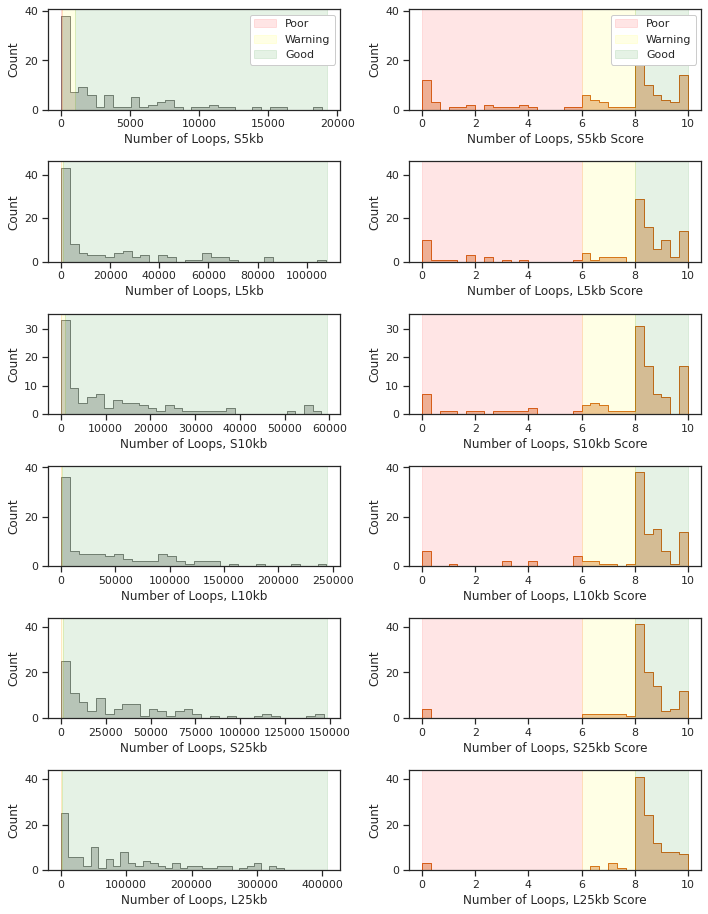

In [190]:
sns.set_theme(style="ticks")

columns_pairs = [
    ("Stringent 5kb", "score_s5"),
    ("Loose 5kb", "score_l5"),
    ("Stringent 10kb", "score_s10"),
    ("Loose 10kb", "score_l10"),
    ("Stringent 25kb", "score_s25"),
    ("Loose 25kb", "score_l25")
]

column_labels = [
    ("Number of Loops, S5kb", "Number of Loops, S5kb Score"),
    ("Number of Loops, L5kb", "Number of Loops, L5kb Score"),
    ("Number of Loops, S10kb", "Number of Loops, S10kb Score"),
    ("Number of Loops, L10kb", "Number of Loops, L10kb Score"),
    ("Number of Loops, S25kb", "Number of Loops, S25kb Score"),
    ("Number of Loops, L25kb", "Number of Loops, L25kb Score")
]

fill_values = [
    [(0, 100), (100, 1000), (1000, upper_bounds[0])],
    [(0, 100), (100, 1000), (1000, upper_bounds[1])],
    [(0, 100), (100, 1000), (1000, upper_bounds[2])],
    [(0, 100), (100, 1000), (1000, upper_bounds[3])],
    [(0, 100), (100, 1000), (1000, upper_bounds[4])],
    [(0, 100), (100, 1000), (1000, upper_bounds[5])]
]

fig, axes = plt.subplots(nrows=len(columns_pairs), ncols=2, figsize=(10.0, 15.0 / 7.0 * len(columns_pairs)))

for i, (col1, col2) in enumerate(columns_pairs):
    #sns.histplot(f[col1], alpha=0.4, bins=30, element="step", color="gray", ax=axes[i, 0])
    sns.histplot(f.loc[f[col1] < upper_bounds[i]][col1], alpha=0.4, bins=30, element="step", color="gray", ax=axes[i, 0])
    y1_max = axes[i, 0].get_ylim()[1]
    
    sns.histplot(np.array(f[col2]), alpha=0.4, color="chocolate", bins=30, element="step", ax=axes[i, 1])
    y2_max = axes[i, 1].get_ylim()[1]

    y_max = max(y1_max, y2_max) * 1.02
    
    fill = fill_values[i]
    axes[i, 0].fill_betweenx(y=[0, y_max], x1=fill[0][0], x2=fill[0][1], color='red', alpha=0.1, label='Poor')
    axes[i, 0].fill_betweenx(y=[0, y_max], x1=fill[1][0], x2=fill[1][1], color='yellow', alpha=0.1, label='Warning')
    axes[i, 0].fill_betweenx(y=[0, y_max], x1=fill[2][0], x2=fill[2][1], color='green', alpha=0.1, label='Good')

    axes[i, 1].fill_betweenx(y=[0, y_max], x1=0, x2=6, color='red', alpha=0.1, label='Poor')
    axes[i, 1].fill_betweenx(y=[0, y_max], x1=6, x2=8, color='yellow', alpha=0.1, label='Warning')
    axes[i, 1].fill_betweenx(y=[0, y_max], x1=8, x2=10, color='green', alpha=0.1, label='Good')

    axes[i, 0].set_ylim(0, y_max)
    axes[i, 1].set_ylim(0, y_max)
    
    labels = column_labels[i]
    axes[i, 0].set_xlabel(labels[0])
    axes[i, 0].set_ylabel('Count')
    axes[i, 1].set_xlabel(labels[1])
    axes[i, 1].set_ylabel('Count')
    
    if i == 0:
        axes[i, 0].legend(loc='upper right', facecolor = "white", framealpha = 1)
        axes[i, 1].legend(loc='upper right', facecolor = "white", framealpha = 1)

plt.tight_layout()
plt.show()

#### Visualization

In [191]:
ctabs = {}
for column in f.filter(regex = (".*AGG.*|.*PREPROCESSING_FLAG.*")):
    ctabs[column] = pd.crosstab(index = f[column], columns = "count")

In [192]:
summary_df = pd.concat({k: v.reset_index() for k, v in ctabs.items()}, axis=1)
summary_df.columns = ['_'.join(col).strip() for col in summary_df.columns.values]

for col in summary_df.columns:
    if "count" not in col:
        check = {"Good" : 0, "Warning" : 0, "Poor" : 0, "nan" : 0}
        currcol = list(summary_df[col])
        for item in currcol:
            if str(item) == "Good":
                check["Good"] = 1
            if str(item) == "Warning":
                check["Warning"] = 1
            if str(item) == "Poor":
                check["Poor"] = 1
            if str(item) == "nan":
                check["nan"] = 1
        if check["nan"] == 1:
            need = [flag for flag in check.keys() if check[flag] == 0]
            count = 0
            for i in currcol:
                if str(i) == "nan":
                    currcol[currcol.index(i)] = need[count]
                    count += 1
        summary_df[col] = currcol

categories = ['Poor', 'Warning', 'Good']

results = {}
columns = [col for col in summary_df.columns if '_FLAG' in col and '_count' not in col]
count_columns = [col for col in summary_df.columns if '_count' in col]

# Loop through each flag column and its corresponding count column
for flag_col, count_col in zip(columns, count_columns):
    # Create a pivot table to count occurrences of 'Good', 'Warning', 'Poor'
    pivot = summary_df.pivot_table(index=flag_col, values=count_col, aggfunc='sum').reindex(categories, fill_value=0)
    
    # Add the results to the dictionary
    results[flag_col] = pivot.squeeze()  # Squeeze to convert to Series

# Convert the dictionary to a DataFrame
final_df = pd.DataFrame(results).T
final_df

Poor  Warning  Good
PREPROCESSING_FLAG_PREPROCESSING_FLAG   0.0     10.0  99.0
PEAKS_AGG_FLAG_PEAKS_AGG_FLAG           9.0     22.0  78.0
LOOPS_AGG_FLAG_S5_LOOPS_AGG_FLAG_S5    30.0     20.0  59.0
LOOPS_AGG_FLAG_L5_LOOPS_AGG_FLAG_L5    22.0     19.0  68.0
LOOPS_AGG_FLAG_S10_LOOPS_AGG_FLAG_S10  20.0     18.0  71.0
LOOPS_AGG_FLAG_L10_LOOPS_AGG_FLAG_L10  18.0     15.0  76.0
LOOPS_AGG_FLAG_S25_LOOPS_AGG_FLAG_S25   9.0     22.0  78.0
LOOPS_AGG_FLAG_L25_LOOPS_AGG_FLAG_L25   9.0     22.0  78.0

In [ ]:
colors = ["lightcoral", "yellow", "yellowgreen"]

final_df.plot(kind='bar', stacked=True, color=colors, edgecolor="black", linewidth = 1)

labels = ["PP HiChIP", 'Peaks', 'S5 Loops', 'L5 Loops', 'S10 Loops', 'L10 Loops', 'S25 Loops', 'L25 Loops'] 
ticks = range(len(labels))
plt.xticks(ticks, labels, rotation=45)

plt.xlabel('Flag')
plt.ylabel('Number of Samples')
plt.title('{o} FH {m}'.format(o = org, m = merge[0].upper() + merge[1:]))
plt.grid(False)

# Create legend patches
legend_patches = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
# Create the legend
plt.legend(legend_patches, ["Poor", "Warning", "Good"], loc='upper left', bbox_to_anchor=(1,1), title='Flag Type')

# Adjust the layout to make room for the legend
plt.tight_layout(rect=[1, 0, .75, 0.75])

plt.savefig('results/figures/qc_flags/{d}/{g}.fh_loops.{m}.{d}.png'.format(g=org, m=merge,d=date1), dpi=1000, bbox_inches='tight')

plt.show()

#### Export to Samplesheet

In [194]:
final = f.filter(regex="^(?!.*score).*", axis=1).drop(columns = ["PREPROCESSING_SCORE", "PEAKS_SCORE", "PEAKS_FLAG", "LOOPS_FLAG_S5", "LOOPS_FLAG_L5", "LOOPS_FLAG_S10", "LOOPS_FLAG_L10", "LOOPS_FLAG_S25", "LOOPS_FLAG_L25", "LOOPS_SCORE_S5", "LOOPS_SCORE_L5", "LOOPS_SCORE_S10", "LOOPS_SCORE_L10", "LOOPS_SCORE_L25", "LOOPS_SCORE_S25"])

In [195]:
final.to_csv("results/tables/update_10.16.2024/tsv/{o}.{m}_qc_flags.fh.10_16_24.tsv".format(o = org, m = merge), sep = "\t", index = False)

In [196]:
final

Sample Name  \
0                    AML12_shCtrl.GSE141113.Mus_Musculus.H3K9me3.biorep_merged   
1                    AML12_shSafb.GSE141113.Mus_Musculus.H3K9me3.biorep_merged   
2                Adult_CTX_SSTcre.GSE150536.Mus_Musculus.H3K27ac.biorep_merged   
3                Adult_CTX_VIPcre.GSE150536.Mus_Musculus.H3K27ac.biorep_merged   
4                   Atria-Control.GSE222370.Mus_Musculus.H3K27ac.biorep_merged   
5                   Atria-TBX5AKO.GSE222370.Mus_Musculus.H3K27ac.biorep_merged   
6                          Atrial.GSE215020.Mus_Musculus.H3K27ac.biorep_merged   
7                     BL6_CD4_CD8.GSE141847.Mus_Musculus.H3K27ac.biorep_merged   
8                       BL6_CD4_CD8.GSE141847.Mus_Musculus.SMC1A.biorep_merged   
9               BMDC-CTCF_cKO-LPS.GSE185883.Mus_Musculus.H3K27ac.biorep_merged   
10                  BMDC-CTCF_cKO.GSE185883.Mus_Musculus.H3K27ac.biorep_merged   
11               BMDC-JSH-JSH-LPS.GSE215044.Mus_Musculus.H3K27ac.biorep_merged   
12                       BMDC-JSH.GSE215044.Mus_Musculus.H3K27ac.biorep_merged   
13                       BMDC-LPS.GSE215044.Mus_Musculus.H3K27ac.biorep_merged   
14                    BMDC-WT-LPS.GSE185883.Mus_Musculus.H3K27ac.biorep_merged   
15                    BMDC-WT-LPS_p65.GSE185883.Mus_Musculus.p65.biorep_merged   
16                        BMDC-WT.GSE185883.Mus_Musculus.H3K27ac.biorep_merged   
17                           BMDC.GSE215044.Mus_Musculus.H3K27ac.biorep_merged   
18                    BMDM_24hIL4.GSE159629.Mus_Musculus.H3K4me3.biorep_merged   
19                     BMDM_Basal.GSE159629.Mus_Musculus.H3K4me3.biorep_merged   
20                     BMDM_EPSKO.GSE115524.Mus_Musculus.H3K4me3.biorep_merged   
21                       BMDM_EPSKO.GSE115524.Mus_Musculus.SMC1A.biorep_merged   
22                     BMDM_EPSWT.GSE115524.Mus_Musculus.H3K4me3.biorep_merged   
23                       BMDM_EPSWT.GSE115524.Mus_Musculus.SMC1A.biorep_merged   
24                          Beta-TC6.GSE214674.Mus_Musculus.PDX1.biorep_merged   
25            Cardiomyocyte-E12.5.GSE222160.Mus_Musculus.H3K27ac.biorep_merged   
26            Cardiomyocyte-E18.5.GSE178673.Mus_Musculus.H3K27ac.biorep_merged   
27               Cardiomyocyte-P3.GSE178673.Mus_Musculus.H3K27ac.biorep_merged   
28              Cardiomyocyte-P42.GSE222160.Mus_Musculus.H3K27ac.biorep_merged   
29                                D3.GSE113339.Mus_Musculus.KLF4.biorep_merged   
30                                D6.GSE113339.Mus_Musculus.KLF4.biorep_merged   
31               E105_Whole_Brain.GSE160656.Mus_Musculus.H3K27ac.biorep_merged   
32                E14_mESC_AntNPC.GSE160656.Mus_Musculus.H3K27ac.biorep_merged   
33                 E14_mESC_EEDko.GSE160656.Mus_Musculus.H3K4me3.biorep_merged   
34             E14_mESC_RINGko_fl.GSE160656.Mus_Musculus.H3K4me3.biorep_merged   
35                   E14_mESC_WT.GSE160656.Mus_Musculus.H3K27me3.biorep_merged   
36                    E14_mESC_WT.GSE160656.Mus_Musculus.H3K4me3.biorep_merged   
37                          EPISC.GSE213644.Mus_Musculus.H3K27ac.biorep_merged   
38                             ES.GSE113339.Mus_Musculus.H3K27ac.biorep_merged   
39                                ES.GSE113339.Mus_Musculus.KLF4.biorep_merged   
40                       ESC-Day0.GSE160943.Mus_Musculus.H3K27ac.biorep_merged   
41                       ESC-Day6.GSE160943.Mus_Musculus.H3K27ac.biorep_merged   
42                               ESC.GSE153884.Mus_Musculus.CTCF.biorep_merged   
43                              ESC.GSE153884.Mus_Musculus.FGFR1.biorep_merged   
44                             EryD.GSE112717.Mus_Musculus.Gata1.biorep_merged   
45                             EryP.GSE112717.Mus_Musculus.Gata1.biorep_merged   
46                  Erythroid_0hr.GSE142004.Mus_Musculus.H3K27ac.biorep_merged   
47                      Erythroid_0hr.GSE142004.Mus_Musculus.YY1.biorep_merged   
48                  Erythroid_1hr.GSE142004.Mus_M

## Follow-Up Analysis

In [54]:
batch1_human = "results/samplesheets/fastq/2024.09.12.10.41.fastq.batch1-human.samplesheet.with_header.tsv"
batch1_mouse = "results/samplesheets/fastq/2024.09.12.10.41.fastq.batch1-mouse.samplesheet.with_header.tsv"
batch2 = "results/samplesheets/fastq/2024.09.12.10.41.fastq.batch2.samplesheet.with_header.tsv"
meta = pd.concat([pd.read_csv(batch1_human, sep="\t", header=0), pd.read_csv(batch1_mouse, sep="\t", header=0), pd.read_csv(batch2, sep="\t", header=0)])
meta = meta.drop_duplicates(subset=["std_sample_name"]).reset_index(drop=True).sort_values(by="std_sample_name")

meta["read_length"] = meta.apply(lambda x : int(x["read_length"]) if "," not in str(x["read_length"]) else int(str(x["read_length"]).split(",")[1]), axis = 1)
meta["year"] = meta.apply(lambda x : x["study"].split(", ")[1], axis = 1)
meta = meta[["std_sample_name", "organism", "antibody_target", "restriction_enzyme", "year", "read_length"]]
meta.columns = ["Sample Name", "organism", "antibody_target", "restriction_enzyme", "year", "read_length"]

In [55]:
all_data = f.merge(meta, on="Sample Name")
all_data

Sample Name  \
0                                   293T-PDS.GSE128106.Homo_Sapiens.YY1.b1   
1                                293T-TMPYP4.GSE128106.Homo_Sapiens.YY1.b1   
2                                       293T.GSE128106.Homo_Sapiens.YY1.b1   
3                                   A375.GSE210423.Homo_Sapiens.H3K27ac.b1   
4                            A673-shFLI1.GSE193830.Homo_Sapiens.H3K27ac.b1   
5                            A673-shFLI1.GSE193830.Homo_Sapiens.H3K27ac.b2   
6                             A673-shGFP.GSE193830.Homo_Sapiens.H3K27ac.b1   
7                             A673-shGFP.GSE193830.Homo_Sapiens.H3K27ac.b2   
8               A673-siCT-Dh1-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1   
9               A673-siCT-Dh1-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b2   
10             A673-siSA2-Dh6-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1   
11             A673-siSA2-Dh6-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b2   
12             A673-siSA2-Dh8-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1   
13             A673-siSA2-Dh8-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b2   
14                               A673_SA1m1.GSE133227.Homo_Sapiens.CTCF.b1   
15                               A673_SA1m1.GSE133227.Homo_Sapiens.CTCF.b2   
16                               A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.b1   
17                               A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.b2   
18                               A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.b3   
19                               A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.b4   
20                               A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.b5   
21                            A673_SA2m1.GSE133227.Homo_Sapiens.H3K27ac.b1   
22                            A673_SA2m1.GSE133227.Homo_Sapiens.H3K27ac.b2   
23                            A673_SA2m1.GSE133227.Homo_Sapiens.H3K27ac.b3   
24                                A673_SA2r.GSE133227.Homo_Sapiens.CTCF.b1   
25                                A673_SA2r.GSE133227.Homo_Sapiens.CTCF.b2   
26                                A673_SA2r.GSE133227.Homo_Sapiens.CTCF.b3   
27                             A673_SA2r.GSE133227.Homo_Sapiens.H3K27ac.b1   
28                             A673_SA2r.GSE133227.Homo_Sapiens.H3K27ac.b2   
29                             A673_SA2r.GSE133227.Homo_Sapiens.H3K27ac.b3   
30                             A673_SA2r.GSE133227.Homo_Sapiens.H3K27ac.b4   
31                             A673_SA2r.GSE133227.Homo_Sapiens.H3K27ac.b5   
32                                  A673_WT.GSE133227.Homo_Sapiens.CTCF.b1   
33                                  A673_WT.GSE133227.Homo_Sapiens.CTCF.b2   
34                                  A673_WT.GSE133227.Homo_Sapiens.CTCF.b3   
35                                  A673_WT.GSE133227.Homo_Sapiens.CTCF.b4   
36                                  A673_WT.GSE133227.Homo_Sapiens.CTCF.b5   
37                               A673_WT.GSE133227.Homo_Sapiens.H3K27ac.b1   
38                               A673_WT.GSE133227.Homo_Sapiens.H3K27ac.b2   
39                               A673_WT.GSE133227.Homo_Sapiens.H3K27ac.b3   
40                               A673_WT.GSE133227.Homo_Sapiens.H3K27ac.b4   
41                                 ARK-1.GSE137936.Homo_Sapiens.H3K27ac.b1   
42                                 AoSMC.GSE178598.Homo_Sapiens.H3K27ac.b1   
43                            Aortic-VIC.GSE154513.Homo_Sapiens.H3K27ac.b1   
44              B-Lymphocyte-EBV-Day0.GSE128952.Homo_Sapiens.RNA-Pol-II.b1   
45              B-Lymphocyte-EBV-Day0.GSE128952.Homo_Sapiens.RNA-Pol-II.b2   
46             B-Lymphocyte-EBV-Day28.GSE128952.Homo_Sapiens.RNA-Pol-II.b1   
47             B-Lymphocyte-EBV-Day28.GSE128952.Homo_Sapiens.RNA-Pol-II.b2   
48                                 B80T5.GSE219164.Homo_Sapiens.H3K27ac.b1   
49                                 B80T5.GSE219164.Homo_Sapiens.H3K27ac.b2   
50                                   BC1.GSE136090.Homo_Sapiens.H3K27ac.b1   
51     

In [69]:
counts = pd.crosstab(all_data["year"], all_data['LOOPS_AGG_FLAG_S10'])
#counts.loc[counts.sum(axis=1) > 10]
counts

LOOPS_AGG_FLAG_S10  Good  Poor  Warning
year                                   
2016                   2     0        0
2017                  15     4        3
2018                  29    12        9
2019                  11    15       10
2020                  34     5       15
2021                 100    38       57
2022                  36    28       18
2023                 116    92       58
2024                  11    39        6

In [67]:
def plot_relationship(var, all_data, org, merge):

    # Calculate counts and proportions
    counts = pd.crosstab(all_data[var], all_data['LOOPS_AGG_FLAG_S10'])
    if var == "antibody_target" or var == "restriction_enzyme":
        counts = counts.loc[counts.sum(axis=1) > 10]
    proportions = counts.div(counts.sum(axis=1), axis=0)
    
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Plot counts
    colors = ["yellowgreen", "yellow", "lightcoral"]
    counts.plot(ax=axes[0], kind='bar', stacked=True, color=colors, edgecolor="black", linewidth=1, legend=False)
    axes[0].set_xlabel(var)
    axes[0].set_ylabel('Number of Samples')

    # Plot proportions
    proportions.plot(ax=axes[1], kind='bar', stacked=True, color=colors, edgecolor="black", linewidth=1, legend=False)
    axes[1].set_xlabel(var)
    axes[1].set_ylabel("Proportion")

    # Rotate x-axis labels for both subplots
    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    # Create custom legend outside the plot
    legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
    fig.legend(legend_patches, ["Good", "Warning", "Poor"], loc='upper left', bbox_to_anchor=(.84, .92), title='Flag Type')
    
    # set title
    fig.suptitle('{o} FH {m}'.format(o = org, m = merge[0].upper() + merge[1:]))
    
    # Adjust layout to fit the plots and the legend properly
    fig.tight_layout(rect=[0, 0, 0.85, 1])

    # Save the figure if needed
    # plt.savefig('results/figures/qc_flags/{g}.fh_loops.{m}.09.11.24.png'.format(g=org, m=merge), dpi=300, bbox_inches='tight')

    # Show the figure
    plt.show()

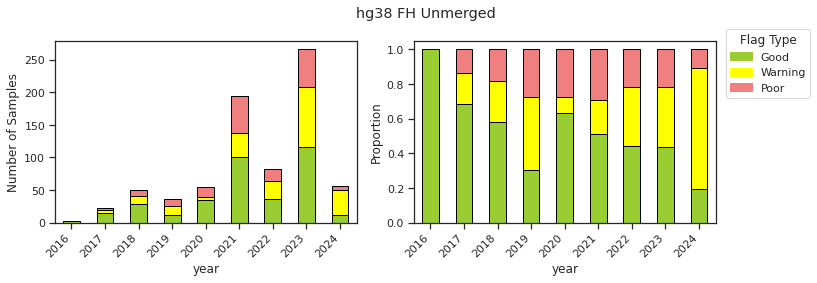

In [68]:
plot_relationship("year", all_data, org, merge)

In [61]:
plot_relationship("antibody_target", all_data, org, merge)

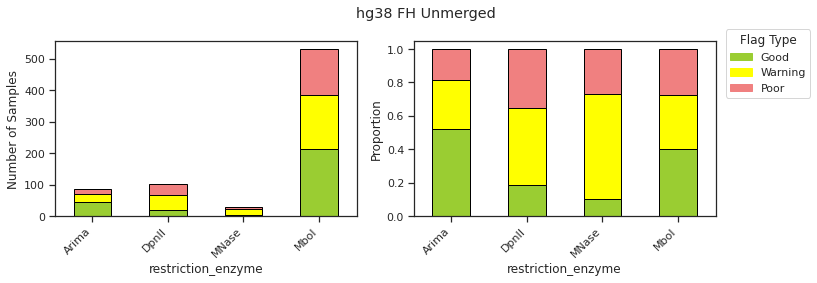

In [62]:
plot_relationship("restriction_enzyme", all_data, org, merge)

In [64]:
def plot_relationship(var, all_data, org, merge):
    
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

    # Plot counts
    colors = ["yellowgreen", "yellow", "lightcoral"]
    sns.histplot(ax=axes, data=all_data, x="read_length", hue="LOOPS_AGG_FLAG_S5", hue_order=["Good", "Warning", "Poor"], multiple="stack", bins=15, palette=colors, edgecolor="black", legend=False)
    axes.set_xlabel(var)
    axes.set_ylabel('Number of Samples')

    # Create custom legend outside the plot
    fig.legend(legend_patches, ["Poor", "Warning", "Good"], loc='upper left', bbox_to_anchor=(.84, .92), title='Flag Type')
    
    # set title
    fig.suptitle('{o} FH {m}'.format(o = org, m = merge[0].upper() + merge[1:]))
    
    # Adjust layout to fit the plots and the legend properly
    fig.tight_layout(rect=[0, 0, 0.85, 1])

    # Save the figure if needed
    # plt.savefig('results/figures/qc_flags/{g}.fh_loops.{m}.09.11.24.png'.format(g=org, m=merge), dpi=300, bbox_inches='tight')

    # Show the figure
    plt.show()

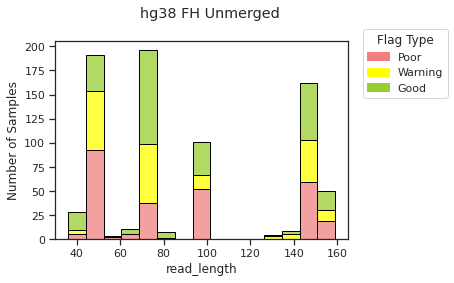

In [65]:
plot_relationship("read_length", all_data, org, merge)

## Visualize

In [2034]:
f = f.drop(columns = ["has_chipseq", "flag_peaks", "flag_S5", "flag_L5", "flag_S10", "flag_L10", "flag_S25", "flag_L25"])

In [2035]:
f

Sample Name  \
0                                   293T-PDS.GSE128106.Homo_Sapiens.YY1.b1   
1                                293T-TMPYP4.GSE128106.Homo_Sapiens.YY1.b1   
2                                       293T.GSE128106.Homo_Sapiens.YY1.b1   
3                                   A375.GSE210423.Homo_Sapiens.H3K27ac.b1   
4                                A673_SA1m1.GSE133227.Homo_Sapiens.CTCF.b1   
5                                A673_SA1m1.GSE133227.Homo_Sapiens.CTCF.b2   
6                                A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.b1   
7                                A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.b2   
8                                A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.b3   
9                                A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.b4   
10                               A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.b5   
11                            A673_SA2m1.GSE133227.Homo_Sapiens.H3K27ac.b1   
12                            A673_SA2m1.GSE133227.Homo_Sapiens.H3K27ac.b2   
13                            A673_SA2m1.GSE133227.Homo_Sapiens.H3K27ac.b3   
14                                A673_SA2r.GSE133227.Homo_Sapiens.CTCF.b1   
15                                A673_SA2r.GSE133227.Homo_Sapiens.CTCF.b2   
16                                A673_SA2r.GSE133227.Homo_Sapiens.CTCF.b3   
17                             A673_SA2r.GSE133227.Homo_Sapiens.H3K27ac.b1   
18                             A673_SA2r.GSE133227.Homo_Sapiens.H3K27ac.b2   
19                             A673_SA2r.GSE133227.Homo_Sapiens.H3K27ac.b3   
20                             A673_SA2r.GSE133227.Homo_Sapiens.H3K27ac.b4   
21                             A673_SA2r.GSE133227.Homo_Sapiens.H3K27ac.b5   
22                                  A673_WT.GSE133227.Homo_Sapiens.CTCF.b1   
23                                  A673_WT.GSE133227.Homo_Sapiens.CTCF.b2   
24                                  A673_WT.GSE133227.Homo_Sapiens.CTCF.b3   
25                                  A673_WT.GSE133227.Homo_Sapiens.CTCF.b4   
26                                  A673_WT.GSE133227.Homo_Sapiens.CTCF.b5   
27                               A673_WT.GSE133227.Homo_Sapiens.H3K27ac.b1   
28                               A673_WT.GSE133227.Homo_Sapiens.H3K27ac.b2   
29                               A673_WT.GSE133227.Homo_Sapiens.H3K27ac.b3   
30                               A673_WT.GSE133227.Homo_Sapiens.H3K27ac.b4   
31              A673-siCT-Dh1-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1   
32              A673-siCT-Dh1-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b2   
33             A673-siSA2-Dh6-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1   
34             A673-siSA2-Dh6-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b2   
35             A673-siSA2-Dh8-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1   
36             A673-siSA2-Dh8-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b2   
37                            Aortic-VIC.GSE154513.Homo_Sapiens.H3K27ac.b1   
38                                 AoSMC.GSE178598.Homo_Sapiens.H3K27ac.b1   
39                                 ARK-1.GSE137936.Homo_Sapiens.H3K27ac.b1   
40                            astrocytes.GSE217349.Homo_Sapiens.H3K4me3.b1   
41              B-Lymphocyte-EBV-Day0.GSE128952.Homo_Sapiens.RNA-Pol-II.b1   
42              B-Lymphocyte-EBV-Day0.GSE128952.Homo_Sapiens.RNA-Pol-II.b2   
43             B-Lymphocyte-EBV-Day28.GSE128952.Homo_Sapiens.RNA-Pol-II.b1   
44             B-Lymphocyte-EBV-Day28.GSE128952.Homo_Sapiens.RNA-Pol-II.b2   
45                                 B80T5.GSE219164.Homo_Sapiens.H3K27ac.b1   
46                                 B80T5.GSE219164.Homo_Sapiens.H3K27ac.b2   
47                                   BC1.GSE136090.Homo_Sapiens.H3K27ac.b1   
48                                   BC3.GSE136090.Homo_Sapiens.H3K27ac.b1   
49                                 BCBL1.GSE136090.Homo_Sapiens.H3K27ac.b1   
50                      Bergeron-697-0hr.GSE188713.Homo_Sapiens.H3K27ac.b1   
51     

In [2036]:
df = f

In [2037]:
def get_protein(name):
    return name.strip().split(".")[-2]

In [2038]:
df["Protein Pulldown"] = df.apply(lambda x : get_protein(x["Sample Name"]), axis = 1)

In [2039]:
df

Sample Name  \
0                                   293T-PDS.GSE128106.Homo_Sapiens.YY1.b1   
1                                293T-TMPYP4.GSE128106.Homo_Sapiens.YY1.b1   
2                                       293T.GSE128106.Homo_Sapiens.YY1.b1   
3                                   A375.GSE210423.Homo_Sapiens.H3K27ac.b1   
4                                A673_SA1m1.GSE133227.Homo_Sapiens.CTCF.b1   
5                                A673_SA1m1.GSE133227.Homo_Sapiens.CTCF.b2   
6                                A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.b1   
7                                A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.b2   
8                                A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.b3   
9                                A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.b4   
10                               A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.b5   
11                            A673_SA2m1.GSE133227.Homo_Sapiens.H3K27ac.b1   
12                            A673_SA2m1.GSE133227.Homo_Sapiens.H3K27ac.b2   
13                            A673_SA2m1.GSE133227.Homo_Sapiens.H3K27ac.b3   
14                                A673_SA2r.GSE133227.Homo_Sapiens.CTCF.b1   
15                                A673_SA2r.GSE133227.Homo_Sapiens.CTCF.b2   
16                                A673_SA2r.GSE133227.Homo_Sapiens.CTCF.b3   
17                             A673_SA2r.GSE133227.Homo_Sapiens.H3K27ac.b1   
18                             A673_SA2r.GSE133227.Homo_Sapiens.H3K27ac.b2   
19                             A673_SA2r.GSE133227.Homo_Sapiens.H3K27ac.b3   
20                             A673_SA2r.GSE133227.Homo_Sapiens.H3K27ac.b4   
21                             A673_SA2r.GSE133227.Homo_Sapiens.H3K27ac.b5   
22                                  A673_WT.GSE133227.Homo_Sapiens.CTCF.b1   
23                                  A673_WT.GSE133227.Homo_Sapiens.CTCF.b2   
24                                  A673_WT.GSE133227.Homo_Sapiens.CTCF.b3   
25                                  A673_WT.GSE133227.Homo_Sapiens.CTCF.b4   
26                                  A673_WT.GSE133227.Homo_Sapiens.CTCF.b5   
27                               A673_WT.GSE133227.Homo_Sapiens.H3K27ac.b1   
28                               A673_WT.GSE133227.Homo_Sapiens.H3K27ac.b2   
29                               A673_WT.GSE133227.Homo_Sapiens.H3K27ac.b3   
30                               A673_WT.GSE133227.Homo_Sapiens.H3K27ac.b4   
31              A673-siCT-Dh1-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1   
32              A673-siCT-Dh1-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b2   
33             A673-siSA2-Dh6-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1   
34             A673-siSA2-Dh6-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b2   
35             A673-siSA2-Dh8-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1   
36             A673-siSA2-Dh8-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b2   
37                            Aortic-VIC.GSE154513.Homo_Sapiens.H3K27ac.b1   
38                                 AoSMC.GSE178598.Homo_Sapiens.H3K27ac.b1   
39                                 ARK-1.GSE137936.Homo_Sapiens.H3K27ac.b1   
40                            astrocytes.GSE217349.Homo_Sapiens.H3K4me3.b1   
41              B-Lymphocyte-EBV-Day0.GSE128952.Homo_Sapiens.RNA-Pol-II.b1   
42              B-Lymphocyte-EBV-Day0.GSE128952.Homo_Sapiens.RNA-Pol-II.b2   
43             B-Lymphocyte-EBV-Day28.GSE128952.Homo_Sapiens.RNA-Pol-II.b1   
44             B-Lymphocyte-EBV-Day28.GSE128952.Homo_Sapiens.RNA-Pol-II.b2   
45                                 B80T5.GSE219164.Homo_Sapiens.H3K27ac.b1   
46                                 B80T5.GSE219164.Homo_Sapiens.H3K27ac.b2   
47                                   BC1.GSE136090.Homo_Sapiens.H3K27ac.b1   
48                                   BC3.GSE136090.Homo_Sapiens.H3K27ac.b1   
49                                 BCBL1.GSE136090.Homo_Sapiens.H3K27ac.b1   
50                      Bergeron-697-0hr.GSE188713.Homo_Sapiens.H3K27ac.b1   
51     

In [2040]:
S5 = df[["Stringent 5kb", "flag_final_S5", "Protein Pulldown"]]

In [2041]:
S5 = S5.loc[S5["flag_final_S5"].str.contains("Warning") | S5["flag_final_S5"].str.contains("Good")].reset_index(drop=True)

In [2042]:
S5["Protein Pulldown"].value_counts()

H3K27ac        282
CTCF            49
SMC1A           31
H3K4me3         17
RNA-Pol-II       8
STAG1            7
Gata1            6
STAG2            6
Rad21            3
AR               3
KLF1             2
OCT4             2
RNAPII-S2ph      1
Name: Protein Pulldown, dtype: int64

In [2043]:
def final_protein(pro):
    if pro in ["H3K27ac", "CTCF", "SMC1A", "H3K4me3"]:
        return pro
    return "Other"

In [2044]:
S5["Protein Pulldown"] = S5.apply(lambda x : final_protein(x["Protein Pulldown"]), axis = 1)

In [2045]:
def anno_protein(pro):
    return pro + "\nn = " + str(S5["Protein Pulldown"].value_counts()[pro]) + " Samples"

In [2046]:
S5["Protein Pulldown"] = S5.apply(lambda x : anno_protein(x["Protein Pulldown"]), axis = 1)

In [2047]:
S5.sort_values(by = "Stringent 5kb")

Stringent 5kb flag_final_S5          Protein Pulldown
382          101.0       Warning   H3K4me3\nn = 17 Samples
179          104.0       Warning  H3K27ac\nn = 282 Samples
289          108.0       Warning     Other\nn = 38 Samples
254          115.0       Warning  H3K27ac\nn = 282 Samples
255          116.0       Warning  H3K27ac\nn = 282 Samples
267          126.0       Warning  H3K27ac\nn = 282 Samples
38           126.0       Warning  H3K27ac\nn = 282 Samples
257          127.0       Warning  H3K27ac\nn = 282 Samples
256          127.0       Warning  H3K27ac\nn = 282 Samples
249          127.0       Warning  H3K27ac\nn = 282 Samples
225          130.0       Warning  H3K27ac\nn = 282 Samples
226          130.0       Warning  H3K27ac\nn = 282 Samples
280          131.0       Warning  H3K27ac\nn = 282 Samples
375          133.0       Warning  H3K27ac\nn = 282 Samples
135          136.0       Warning  H3K27ac\nn = 282 Samples
56           139.0       Warning  H3K27ac\nn = 282 Samples
276          140.0       Warning  H3K27ac\nn = 282 Samples
115          155.0       Warning      CTCF\nn = 49 Samples
315          159.0       Warning     SMC1A\nn = 31 Samples
41           162.0       Warning  H3K27ac\nn = 282 Samples
339          167.0       Warning  H3K27ac\nn = 282 Samples
103          173.0       Warning  H3K27ac\nn = 282 Samples
210          174.0       Warning  H3K27ac\nn = 282 Samples
161          175.0       Warning  H3K27ac\nn = 282 Samples
374          178.0       Warning  H3K27ac\nn = 282 Samples
320          179.0       Warning      CTCF\nn = 49 Samples
154          180.0       Warning     SMC1A\nn = 31 Samples
164          180.0       Warning  H3K27ac\nn = 282 Samples
346          184.0       Warning      CTCF\nn = 49 Samples
101          184.0       Warning  H3K27ac\nn = 282 Samples
142          185.0       Warning  H3K27ac\nn = 282 Samples
152          188.0       Warning     SMC1A\nn = 31 Samples
6            188.0       Warning      CTCF\nn = 49 Samples
271          195.0       Warning  H3K27ac\nn = 282 Samples
7            204.0       Warning      CTCF\nn = 49 Samples
122          207.0       Warning     Other\nn = 38 Samples
120          208.0       Warning     Other\nn = 38 Samples
169          209.0       Warning  H3K27ac\nn = 282 Samples
385          217.0       Warning   H3K4me3\nn = 17 Samples
109          219.0       Warning     Other\nn = 38 Samples
124          222.0       Warning     Other\nn = 38 Samples
349          227.0       Warning      CTCF\nn = 49 Samples
175          228.0       Warning  H3K27ac\nn = 282 Samples
3            234.0       Warning      CTCF\nn = 49 Samples
223          243.0       Warning  H3K27ac\nn = 282 Samples
272          244.0       Warning  H3K27ac\nn = 282 Samples
141          245.0       Warning     Other\nn = 38 Samples
8            248.0       Warning      CTCF\nn = 49 Samples
265          251.0       Warning  H3K27ac\nn = 282 Samples
393          254.0       Warning     Other\nn = 38 Samples
287          259.0       Warning  H3K27ac\nn = 282 Samples
296          263.0       Warning     Other\nn = 38 Samples
347          267.0       Warning  H3K27ac\nn = 282 Samples
222          267.0       Warning  H3K27ac\nn = 282 Samples
172          267.0       Warning  H3K27ac\nn = 282 Samples
32           289.0       Warning  H3K27ac\nn = 282 Samples
202          289.0       Warning  H3K27ac\nn = 282 Samples
310          290.0       Warning  H3K27ac\nn = 282 Samples
77           298.0       Warning  H3K27ac\nn = 282 Samples
55           301.0       Warning  H3K27ac\nn = 282 Samples
78           304.0       Warning  H3K27ac\nn = 282 Samples
196          320.0       Warning  H3K27ac\nn = 282 Samples
337          321.0       Warning  H3K27ac\nn = 282 Samples
106          332.0       Warning     Other\nn = 38 Samples
31           340.0       Warning  H3K27ac\nn = 282 Samples
273          347.0       Warning  H3K27ac\nn = 282 Samples
383          354.0       Warning   H3K4me3\nn = 17 S

In [2054]:
ax = sns.violinplot(data=S5, x="Protein Pulldown", y="Stringent 5kb", cut=0, order=["H3K27ac\nn = 282 Samples", "CTCF\nn = 49 Samples", "SMC1A\nn = 31 Samples", "H3K4me3\nn = 17 Samples", "Other\nn = 38 Samples"], palette = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000"])
ax.set_ylabel("Number of FH Loops (Stringent 5kb)")

Text(0, 0.5, 'Number of FH Loops (Stringent 5kb)')

In [2055]:
fig = ax.get_figure()
fig.savefig("results/figures/loops/fh_protein_human.png", dpi = 1000, bbox_inches='tight')

### Peaks Analysis

In [72]:
# length 314 because one sample exclusively has ChIP-seq peaks
peaks = f[["Sample", "Peaks", "S5", "L5", "S10", "L10", "S25", "L25", "Peaks Flag", "Loops Flag"]].merge(c[["Sample", "Peaks", "S5", "L5", "S10", "L10", "S25", "L25", "Peaks Flag", "Loops Flag"]], on = "Sample")

In [74]:
peaks.columns = ["Sample", "FHP", "S5_FHP", "L5_FHP", "S10_FHP", "L10_FHP", "S25_FHP", "L25_FHP", "Peaks Flag FHP", "Loops Flag FHP", "CSP", "S5_CSP", "L5_CSP", "S10_CSP", "L10_CSP", "S25_CSP", "L25_CSP", "Peaks Flag CSP", "Loops Flag CSP"]

/tmp/ipykernel_39298/655491509.py:17: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


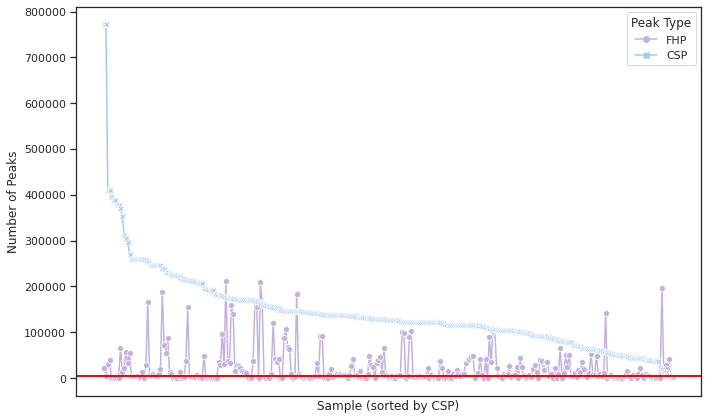

In [75]:
# Sort the data by 'Peaks_y' in decreasing order
sorted_data = peaks.sort_values(by='CSP', ascending=False)

# Create a new DataFrame for plotting with sorted data
sorted_plot_data = sorted_data.melt(id_vars='Sample', value_vars=['FHP', 'CSP'], 
                                    var_name='Peak Type', value_name='Peaks')

# Create the plot with sorted data
colors = {'FHP': '#C3B1E1', 'CSP': '#a1c9f4'}
plt.figure(figsize=(10, 6))
sns.lineplot(data=sorted_plot_data, x='Sample', y='Peaks', hue='Peak Type', 
             style='Peak Type', markers=True, dashes=False, palette=colors)

plt.axhline(5000, color='red', linewidth=2)

# Remove the sample names from the x-axis
plt.xticks([]) 
plt.xlabel('Sample (sorted by CSP)')
plt.ylabel('Number of Peaks')
#plt.title('Comparison of Peaks_x and Peaks_y Across Samples (Sorted by Peaks_y)')
plt.legend(title='Peak Type')

# Show the plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_39298/2863198131.py:17: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


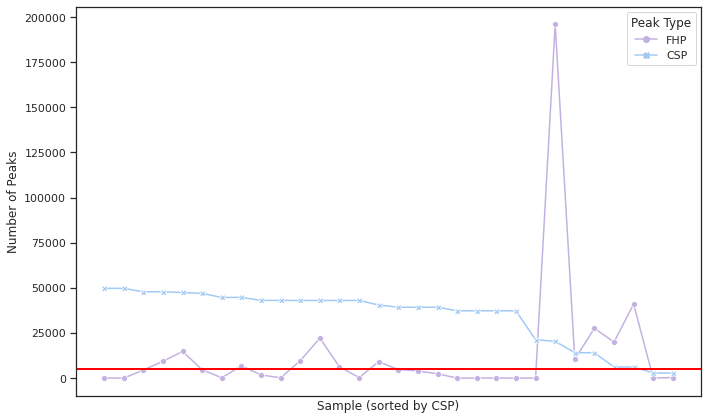

In [76]:
# Sort the data by 'Peaks_y' in decreasing order
sorted_data = peaks.sort_values(by='CSP', ascending=False).loc[peaks["CSP"] <= 50000]

# Create a new DataFrame for plotting with sorted data
sorted_plot_data = sorted_data.melt(id_vars='Sample', value_vars=['FHP', 'CSP'], 
                                    var_name='Peak Type', value_name='Peaks')

# Create the plot with sorted data
colors = {'FHP': '#C3B1E1', 'CSP': '#a1c9f4'}
plt.figure(figsize=(10, 6))
sns.lineplot(data=sorted_plot_data, x='Sample', y='Peaks', hue='Peak Type', 
             style='Peak Type', markers=True, dashes=False, palette=colors)

plt.axhline(5000, color='red', linewidth=2)

# Remove the sample names from the x-axis
plt.xticks([]) 
plt.xlabel('Sample (sorted by CSP)')
plt.ylabel('Number of Peaks')
#plt.title('Comparison of Peaks_x and Peaks_y Across Samples (Sorted by Peaks_y)')
plt.legend(title='Peak Type')

# Show the plot
plt.tight_layout()
plt.show()

In [77]:
peaks.sort_values(by="CSP")

Sample  \
23                                 BMDC-CTCF_cKO-LPS.GSE185883.Mus_Musculus.H3K27ac.b1   
24                                 BMDC-CTCF_cKO-LPS.GSE185883.Mus_Musculus.H3K27ac.b2   
96                                         Erythroid_0hr.GSE142004.Mus_Musculus.YY1.b2   
95                                         Erythroid_0hr.GSE142004.Mus_Musculus.YY1.b1   
98                                         Erythroid_1hr.GSE142004.Mus_Musculus.YY1.b2   
97                                         Erythroid_1hr.GSE142004.Mus_Musculus.YY1.b1   
158                                             L2-3.GSE232458.Mus_Musculus.H3K27ac.b1   
153                                                Jurkat.GSE99519.Homo_Sapiens.YY1.b1   
67                                                   D6.GSE113339.Mus_Musculus.KLF4.b1   
68                                                   D6.GSE113339.Mus_Musculus.KLF4.b2   
69                                                   D6.GSE113339.Mus_Musculus.KLF4.b3   
70                                                   D6.GSE113339.Mus_Musculus.KLF4.b4   
65                                                   D3.GSE113339.Mus_Musculus.KLF4.b2   
64                                                   D3.GSE113339.Mus_Musculus.KLF4.b1   
66                                                   D3.GSE113339.Mus_Musculus.KLF4.b3   
182                                  MDA-MB-453-DMSO.GSE157381.Homo_Sapiens.H3K27ac.b1   
88                                                   ES.GSE113339.Mus_Musculus.KLF4.b3   
87                                                   ES.GSE113339.Mus_Musculus.KLF4.b2   
89                                                   ES.GSE113339.Mus_Musculus.KLF4.b4   
86                                                   ES.GSE113339.Mus_Musculus.KLF4.b1   
25                                     BMDC-CTCF_cKO.GSE185883.Mus_Musculus.H3K27ac.b1   
26                                     BMDC-CTCF_cKO.GSE185883.Mus_Musculus.H3K27ac.b2   
44                                             Beta-TC6.GSE214674.Mus_Musculus.PDX1.b2   
43                                             Beta-TC6.GSE214674.Mus_Musculus.PDX1.b1   
278                                        U3078-GBM.GSE217349.Homo_Sapiens.H3K4me3.b1   
181                           MDA-MB-453-Abemaciclib.GSE157381.Homo_Sapiens.H3K27ac.b1   
83                                             EPISC.GSE213644.Mus_Musculus.H3K27ac.b2   
82                                             EPISC.GSE213644.Mus_Musculus.H3K27ac.b1   
124                                     HCT116-FOXD2.GSE196920.Homo_Sapiens.H3K4me3.b1   
125                                     HCT116-FOXD2.GSE196920.Homo_Sapiens.H3K4me3.b2   
137                                           HCT116.GSE196920.Homo_Sapiens.H3K4me3.b2   
136                                           HCT116.GSE196920.Homo_Sapiens.H3K4me3.b1   
129                                 HCT116-NUP93-mAC.GSE165463.Homo_Sapiens.H3K27ac.b2   
128                                 HCT116-NUP93-mAC.GSE165463.Homo_Sapiens.H3K27ac.b1   
276                                        U3054-GBM.GSE217349.Homo_Sapiens.H3K4me3.b1   
185                                          MLL_AF9.GSE110898.Mus_Musculus.H3K27ac.b1   
149                                        JN-DSRCT1.GSE212978.Homo_Sapiens.H3K27ac.b1   
157                                    L2-3-Kdm5d-KO.GSE232458.Mus_Musculus.H3K27ac.b1   
100                                        Extra-ESC.GSE213644.Mus_Musculus.H3K27ac.b2   
99                                         Extra-ESC.GSE213644.Mus_Musculus.H3K27ac.b1   
186                                    MLL_AF9_LSD1i.GSE110898.Mus_Musculus.H3K27ac.b1   
275                                        U3042-GBM.GSE217349.Homo_Sapiens.H3K4me3.b1   
105                                               H9-HS.GSE105028.Homo_Sapiens.CTCF.b1   
174                                        MCF7-DMSO.GSE157381.Homo_Sapiens.H3K27ac.b1   
311                           

In [78]:
peaks.loc[peaks["FHP"] < 5000].describe()

FHP        S5_FHP       L5_FHP       S10_FHP       L10_FHP  \
count   132.000000    132.000000   132.000000    132.000000    132.000000   
mean   1499.325758    441.409091   896.636364    778.250000   2054.250000   
std    1574.369621   1754.362279  1623.825463   3268.522822   3432.289891   
min       0.000000      0.000000     0.000000      0.000000      0.000000   
25%     101.750000      0.000000     1.000000      0.000000     15.500000   
50%     829.500000      3.000000    41.500000     37.500000    169.000000   
75%    2776.250000    115.250000   963.250000    296.500000   2869.750000   
max    4774.000000  13185.000000  8074.000000  28672.000000  15757.000000   

            S25_FHP       L25_FHP  Peaks Flag FHP  Loops Flag FHP  \
count    132.000000    132.000000      132.000000      132.000000   
mean    1498.500000   4782.916667        0.545455        0.568182   
std     2761.302908   7085.826638        0.499826        0.497216   
min        0.000000      0.000000        0.000000        0.000000   
25%        0.000000     80.000000        0.000000        0.000000   
50%      262.000000   1412.000000        1.000000        1.000000   
75%     1592.500000   6184.000000        1.000000        1.000000   
max    16531.000000  29282.000000        1.000000        1.000000   

                 CSP        S5_CSP        L5_CSP       S10_CSP        L10_CSP  \
count     132.000000    132.000000    132.000000    132.000000     132.000000   
mean   138919.787879   2901.818182   6327.007576  10085.439394   22088.984848   
std     78201.256112   5495.322885  11205.725708  19435.908763   37760.684660   
min      2829.000000      0.000000      0.000000      0.000000       0.000000   
25%     98233.000000      4.750000      8.750000    225.250000     552.500000   
50%    127449.500000    159.000000    464.500000   3058.500000    6841.000000   
75%    169621.000000   2938.000000   5519.500000   9999.000000   25565.000000   
max    394502.000000  24616.000000  45430.000000  96911.000000  176282.000000   

             S25_CSP        L25_CSP  Peaks Flag CSP  Loops Flag CSP  
count     132.000000     132.000000           132.0      132.000000  
mean    32837.484848   59099.045455             0.0        0.196970  
std     44378.385884   72750.253543             0.0        0.399224  
min         0.000000       0.000000             0.0        0.000000  
25%      5188.750000    9081.750000             0.0        0.000000  
50%     14763.000000   38740.000000             0.0        0.000000  
75%     37853.250000   67453.000000             0.0        0.000000  
max    192542.000000  313922.000000             0.0        1.000000

In [79]:
c.describe()

Index   Total Pairs    Validpairs          Peaks             S5  \
count   315.000000  3.150000e+02  3.150000e+02     315.000000     315.000000   
mean    465.587302  2.410940e+08  1.014170e+08  143159.250794   14738.984127   
std     280.083190  2.359132e+08  1.041700e+08   89744.451245   28378.298028   
min       1.000000  2.035761e+06  1.658719e+06    2829.000000       0.000000   
25%     190.500000  1.125037e+08  3.828495e+07   96131.000000      72.000000   
50%     499.000000  2.005462e+08  7.722858e+07  127560.000000    2210.000000   
75%     652.500000  2.788080e+08  1.167044e+08  169621.000000   15666.500000   
max    1044.000000  2.125337e+09  8.544524e+08  771880.000000  196151.000000   

                  L5            S10           L10            S25  \
count     315.000000     315.000000     315.00000     315.000000   
mean    37600.511111   23886.444444   58479.60000   45735.860317   
std     72817.320859   38649.879670   86309.15165   60827.580501   
min         0.000000       0.000000       0.00000       0.000000   
25%       132.000000    1294.500000    3307.00000    8884.500000   
50%      5302.000000    8758.000000   23747.00000   24807.000000   
75%     38966.000000   25606.500000   70930.00000   54568.500000   
max    481466.000000  247293.000000  470701.00000  422546.000000   

                 L25  Pairs Flag  Peaks Flag  Loops Flag  
count     315.000000         0.0       315.0  315.000000  
mean    89572.641270         NaN         0.0    0.095238  
std     97166.543138         NaN         0.0    0.294011  
min         0.000000         NaN         0.0    0.000000  
25%     19695.500000         NaN         0.0    0.000000  
50%     55596.000000         NaN         0.0    0.000000  
75%    131205.000000         NaN         0.0    0.000000  
max    507797.000000         NaN         0.0    1.000000

In [80]:
f.loc[f["has_chipseq"] == False].describe()

Index   Total Pairs    Validpairs          Peaks             S5  \
count   722.000000  7.220000e+02  7.220000e+02     722.000000     722.000000   
mean    544.128809  1.969118e+08  8.577729e+07   31872.822715    7162.596953   
std     307.246658  2.016959e+08  1.013364e+08   43077.439188   16864.306890   
min       4.000000  2.003312e+06  7.925000e+03       0.000000       0.000000   
25%     283.250000  6.983086e+07  2.553547e+07    2249.250000       4.000000   
50%     524.500000  1.402473e+08  5.558146e+07   17228.000000     291.000000   
75%     812.750000  2.576760e+08  1.074781e+08   43803.750000    4876.500000   
max    1043.000000  2.431298e+09  1.086423e+09  301519.000000  155126.000000   

                  L5            S10            L10            S25  \
count     722.000000     722.000000     722.000000     722.000000   
mean    36585.211911   13589.867036   53307.013850   26509.771468   
std     83703.971731   29154.421459  101996.442113   57126.321464   
min         0.000000       0.000000       0.000000       0.000000   
25%        20.000000      34.250000     142.500000     398.500000   
50%      2029.000000    1608.500000    6612.000000    5851.500000   
75%     24726.250000   12284.500000   55719.750000   32483.500000   
max    690130.000000  287841.000000  774957.000000  675732.000000   

                 L25  Pairs Flag  Peaks Flag  Loops Flag  
count     722.000000         0.0  722.000000  722.000000  
mean    69858.824100         NaN    0.189751    0.254848  
std    108587.006768         NaN    0.392376    0.436078  
min         0.000000         NaN    0.000000    0.000000  
25%      1267.500000         NaN    0.000000    0.000000  
50%     23341.000000         NaN    0.000000    0.000000  
75%     97464.750000         NaN    0.000000    1.000000  
max    861913.000000         NaN    1.000000    1.000000

## Sample Set Designations

In [258]:
c_unmerged = pd.read_excel("results/tables/update_07.01.2024/xlsx/hg38.unmerged_loops.chipseq.07_01_24.xlsx")
c_unmerged = c_unmerged.drop(columns=["Unnamed: 0"])

c_merged = pd.read_excel("results/tables/update_07.01.2024/xlsx/hg38.merged_loops.chipseq.07_01_24.xlsx")
c_merged = c_merged.drop(columns=["Unnamed: 0"])

c_megamerged = pd.read_excel("results/tables/update_07.01.2024/xlsx/hg38.mega-merged_loops.chipseq.07_01_24.xlsx")
c_megamerged = c_megamerged.drop(columns=["Unnamed: 0"])

In [259]:
c_all = pd.concat([c_megamerged, c_merged, c_unmerged], ignore_index=True)
c_all.columns = ["std_sample_name", "CP", "FC_S5", "FC_L5", "FC_S10", "FC_L10", "FC_S25", "FC_L25"]
c_all

std_sample_name  \
0                CD4_Naive_All-Donors.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
1                CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
2                 Monocyte_All-Donors.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
3                  Naive_B_All-Donors.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
4           Natural_Killer_All-Donors.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
5    Nonclassical_Monocyte_All-Donors.phs001703v4p1.Homo_Sapiens.H3K27ac.biorep_merged   
6                A673-siCT-Dh1-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.biorep_merged   
7               A673-siSA2-Dh6-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.biorep_merged   
8               A673-siSA2-Dh8-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.biorep_merged   
9                 CD4_Naive_1815-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
10                CD4_Naive_1829-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
11                CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
12                           HCT116-FOXD2.GSE196920.Homo_Sapiens.H3K27ac.biorep_merged   
13                           HCT116-FOXD2.GSE196920.Homo_Sapiens.H3K4me1.biorep_merged   
14                   HCT116-NUP93-mAC-IAA.GSE165463.Homo_Sapiens.H3K27ac.biorep_merged   
15                       HCT116-NUP93-mAC.GSE165463.Homo_Sapiens.H3K27ac.biorep_merged   
16                                 HCT116.GSE196920.Homo_Sapiens.H3K27ac.biorep_merged   
17                                 HCT116.GSE196920.Homo_Sapiens.H3K4me1.biorep_merged   
18                                 HCT116.GSE196920.Homo_Sapiens.H3K4me3.biorep_merged   
19                         HeLa-S3-shBHLHE40.GSE137849.Homo_Sapiens.CTCF.biorep_merged   
20                         HeLa-S3-shcontrol.GSE137849.Homo_Sapiens.CTCF.biorep_merged   
21                                Hela-S3-OE.GSE108869.Homo_Sapiens.CTCF.biorep_merged   
22                                 L3.6pl.GSE213385.Homo_Sapiens.H3K27ac.biorep_merged   
23                                  LHSAR.GSE235245.Homo_Sapiens.H3K27ac.biorep_merged   
24                                  LNCaP.GSE235245.Homo_Sapiens.H3K27ac.biorep_merged   
25                  MDA-MB-231-PVT1sgRNAR2.GSE97585.Homo_Sapiens.H3K27ac.biorep_merged   
26                  MDA-MB-231-PVT1sgRNAR3.GSE97585.Homo_Sapiens.H3K27ac.biorep_merged   
27                   MDA-MB-231-sgRNA-Ctrl.GSE97585.Homo_Sapiens.H3K27ac.biorep_merged   
28                 Monocyte_1800-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
29                 Monocyte_1814-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
30                 Monocyte_1816-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
31                              NK92-SAHA.GSE227663.Homo_Sapiens.H3K27ac.biorep_merged   
32                                   NK92.GSE227663.Homo_Sapiens.H3K27ac.biorep_merged   
33                            NSD2-High-NTKO.GSE131651.Homo_Sapiens.CTCF.biorep_merged   
34                              NSD2-Low-TKO.GSE131651.Homo_Sapiens.CTCF.biorep_merged   
35                       OCI-AML3-DeltaSTAG2.GSE111537.Homo_Sapiens.CTCF.biorep_merged   
36                               OCI-AML3-WT.GSE111537.Homo_Sapiens.CTCF.biorep_merged   
37                                 SNU719.GSE239992.Homo_Sapiens.H3K27ac.biorep_merged   
38                                 STAG2-KO.GSE116495.Homo_Sapiens.SMC1A.biorep_merged   
39                                 STAG2-WT.GSE116495.Homo_Sapiens.SMC1A.biorep_merged   
40                         Wei-22RV1-Control.GSE200165.Homo_Sapiens.CTCF.biorep_merged   
41                      Wei-22RV1-Control.GSE200165.Homo_Sapiens.H3K27ac.biorep_merged   
42                             Wei-22RV1-Myc.GSE200165.Homo_Sapiens.CTCF.biorep_merged   
43                          Wei-22RV1-Myc.GSE200165.Homo_Sapiens.H3K27ac.biorep_merged   
44                   

In [260]:
hiccups_unmerged = pd.read_excel("results/tables/update_07.01.2024/xlsx/hg38.unmerged_loops.hiccups.07_01_24.xlsx")
hiccups_unmerged = hiccups_unmerged.drop(columns=["Unnamed: 0"])

hiccups_merged = pd.read_excel("results/tables/update_07.01.2024/xlsx/hg38.merged_loops.hiccups.07_01_24.xlsx")
hiccups_merged = hiccups_merged.drop(columns=["Unnamed: 0"])

hiccups_megamerged = pd.read_excel("results/tables/update_07.01.2024/xlsx/hg38.mega-merged_loops.hiccups.07_01_24.xlsx")
hiccups_megamerged = hiccups_megamerged.drop(columns=["Unnamed: 0"])

In [261]:
hiccups_all = pd.concat([hiccups_megamerged, hiccups_merged, hiccups_unmerged], ignore_index=True)
hiccups_all.columns = ["std_sample_name", "HiCCUPS_5kb", "HiCCUPS_10kb", "HiCCUPS_25kb"]
hiccups_all

std_sample_name  \
0               CD4_Naive_All-Donors.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
1               CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
2                Monocyte_All-Donors.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
3                 Naive_B_All-Donors.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
4          Natural_Killer_All-Donors.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
5                            A673-shFLI1.GSE193830.Homo_Sapiens.H3K27ac.biorep_merged   
6                             A673-shGFP.GSE193830.Homo_Sapiens.H3K27ac.biorep_merged   
7                                A673_SA1m1.GSE133227.Homo_Sapiens.CTCF.biorep_merged   
8                                A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.biorep_merged   
9                                 A673_SA2r.GSE133227.Homo_Sapiens.CTCF.biorep_merged   
10                             A673_SA2r.GSE133227.Homo_Sapiens.H3K27ac.biorep_merged   
11                                  A673_WT.GSE133227.Homo_Sapiens.CTCF.biorep_merged   
12                               A673_WT.GSE133227.Homo_Sapiens.H3K27ac.biorep_merged   
13                                 B80T5.GSE219164.Homo_Sapiens.H3K27ac.biorep_merged   
14                        CAR-T-CD19-D10.GSE168881.Homo_Sapiens.H3K27ac.biorep_merged   
15                          CAR-T-HA-D10.GSE168881.Homo_Sapiens.H3K27ac.biorep_merged   
16               CD4_Naive_1815-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
17               CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
18                               Caudate.GSE147672.Homo_Sapiens.H3K27ac.biorep_merged   
19                                 DND41.GSE165207.Homo_Sapiens.H3K27ac.biorep_merged   
20              Erythroid-progenitor-Day12.GSE214807.Homo_Sapiens.Gata1.biorep_merged   
21               Erythroid-progenitor-Day5.GSE214807.Homo_Sapiens.Gata1.biorep_merged   
22                                 FUUR1.GSE162068.Homo_Sapiens.H3K27ac.biorep_merged   
23                               GM12878.GSE101498.Homo_Sapiens.H3K27ac.biorep_merged   
24                                  GM12878.GSE115524.Homo_Sapiens.CTCF.biorep_merged   
25                                  GM12878.GSE80820.Homo_Sapiens.SMC1A.biorep_merged   
26                              H9-PH.GSE210525.Homo_Sapiens.RNA-Pol-II.biorep_merged   
27                              H9-PP.GSE210525.Homo_Sapiens.RNA-Pol-II.biorep_merged   
28                            H9-TFAP2A_KO.GSE225922.Homo_Sapiens.SMC1A.biorep_merged   
29                                      H9.GSE210525.Homo_Sapiens.STAG1.biorep_merged   
30                                      H9.GSE210525.Homo_Sapiens.STAG2.biorep_merged   
31                          HCT116-FOXD2.GSE196920.Homo_Sapiens.H3K27ac.biorep_merged   
32                          HCT116-FOXD2.GSE196920.Homo_Sapiens.H3K4me1.biorep_merged   
33                                HCT116.GSE196920.Homo_Sapiens.H3K27ac.biorep_merged   
34                                HCT116.GSE196920.Homo_Sapiens.H3K4me1.biorep_merged   
35                                HCT116.GSE196920.Homo_Sapiens.H3K4me3.biorep_merged   
36                           Hippocampus.GSE147672.Homo_Sapiens.H3K27ac.biorep_merged   
37                         IMR90-Control.GSE232942.Homo_Sapiens.H3K27ac.biorep_merged   
38                             IMR90-OIS.GSE232942.Homo_Sapiens.H3K27ac.biorep_merged   
39                   K562-dTAG-BRD4-DMSO.GSE214591.Homo_Sapiens.H3K27ac.biorep_merged   
40                  K562-dTAG-BRD4-dTAG7.GSE214591.Homo_Sapiens.H3K27ac.biorep_merged   
41                                  K562.GSE101498.Homo_Sapiens.H3K27ac.biorep_merged   
42                         K5plusK19plus.GSE219164.Homo_Sapiens.H3K27ac.biorep_merged   
43               KBM7-MED14-dTAG_2h_DMSO.GSE139466.Homo_Sapiens.H3K27ac.biorep_merged   
44              KBM7-MED14-dTAG_2h_dTAG7.GSE139466.Homo_Sapiens.H

In [263]:
df = c_all.merge(hiccups_all, on = "std_sample_name").reset_index(drop = True)

In [265]:
hicpro_unmerged = pd.read_excel("results/tables/update_07.01.2024/xlsx/hg38.unmerged_hicpro.07_01_24.xlsx")
hicpro_unmerged = hicpro_unmerged.drop(columns=["Unnamed: 0"])

hicpro_merged = pd.read_excel("results/tables/update_07.01.2024/xlsx/hg38.merged_hicpro.07_01_24.xlsx")
hicpro_merged = hicpro_merged.drop(columns=["Unnamed: 0"])

hicpro_megamerged = pd.read_excel("results/tables/update_07.01.2024/xlsx/hg38.mega-merged_hicpro.07_01_24.xlsx")
hicpro_megamerged = hicpro_megamerged.drop(columns=["Unnamed: 0"])

In [266]:
hicpro_all = pd.concat([hicpro_megamerged, hicpro_merged, hicpro_unmerged], ignore_index=True)

In [267]:
df = df.merge(hicpro_all, on = "std_sample_name").reset_index(drop = True)

In [268]:
df

std_sample_name  \
0        CD4_Naive_All-Donors.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
1        CD8_Naive_All-Donors.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
2         Monocyte_All-Donors.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
3          Naive_B_All-Donors.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
4   Natural_Killer_All-Donors.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
5         CD4_Naive_1815-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
6         CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
7                    HCT116-FOXD2.GSE196920.Homo_Sapiens.H3K27ac.biorep_merged   
8                    HCT116-FOXD2.GSE196920.Homo_Sapiens.H3K4me1.biorep_merged   
9                          HCT116.GSE196920.Homo_Sapiens.H3K27ac.biorep_merged   
10                         HCT116.GSE196920.Homo_Sapiens.H3K4me1.biorep_merged   
11                         HCT116.GSE196920.Homo_Sapiens.H3K4me3.biorep_merged   
12                          LHSAR.GSE235245.Homo_Sapiens.H3K27ac.biorep_merged   
13                          LNCaP.GSE235245.Homo_Sapiens.H3K27ac.biorep_merged   
14          MDA-MB-231-PVT1sgRNAR2.GSE97585.Homo_Sapiens.H3K27ac.biorep_merged   
15          MDA-MB-231-PVT1sgRNAR3.GSE97585.Homo_Sapiens.H3K27ac.biorep_merged   
16           MDA-MB-231-sgRNA-Ctrl.GSE97585.Homo_Sapiens.H3K27ac.biorep_merged   
17         Monocyte_1814-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
18         Monocyte_1816-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged   
19                      NK92-SAHA.GSE227663.Homo_Sapiens.H3K27ac.biorep_merged   
20                           NK92.GSE227663.Homo_Sapiens.H3K27ac.biorep_merged   
21                         SNU719.GSE239992.Homo_Sapiens.H3K27ac.biorep_merged   
22                 Wei-22RV1-Control.GSE200165.Homo_Sapiens.CTCF.biorep_merged   
23              Wei-22RV1-Control.GSE200165.Homo_Sapiens.H3K27ac.biorep_merged   
24                     Wei-22RV1-Myc.GSE200165.Homo_Sapiens.CTCF.biorep_merged   
25                  Wei-22RV1-Myc.GSE200165.Homo_Sapiens.H3K27ac.biorep_merged   
26                         Wei-22RV1.GSE200165.Homo_Sapiens.CTCF.biorep_merged   
27                         YCCEL1.GSE239992.Homo_Sapiens.H3K27ac.biorep_merged   
28                          CD34+-Cord-Blood.GSE165207.Homo_Sapiens.H3K27ac.b1   
29                   CD4_Naive_1816-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
30                   CD8_Naive_1816-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
31                                    DCM_10.GSE165303.Homo_Sapiens.H3K27ac.b1   
32                                     DCM_2.GSE165303.Homo_Sapiens.H3K27ac.b1   
33                                     DCM_3.GSE165303.Homo_Sapiens.H3K27ac.b1   
34                                     DCM_4.GSE165303.Homo_Sapiens.H3K27ac.b1   
35                                     DCM_9.GSE165303.Homo_Sapiens.H3K27ac.b1   
36                                        H9-HS.GSE105028.Homo_Sapiens.CTCF.b1   
37                                       H9-HS.GSE105028.Homo_Sapiens.Rad21.b1   
38                                           H9.GSE105028.Homo_Sapiens.CTCF.b1   
39                                          H9.GSE105028.Homo_Sapiens.Rad21.b1   
40                        HCT116-AuxinNeg.GSE179544.Homo_Sapiens.RNA-Pol-II.b1   
41                              Hela-S3-Control.GSE108869.Homo_Sapiens.CTCF.b1   
42                              Hela-S3-Control.GSE108869.Homo_Sapiens.CTCF.b2   
43                        JN-DSRCT1.shEWSWT1.GSE212978.Homo_Sapiens.H3K27ac.b1   
44                           JN-DSRCT1.shGFP.GSE212978.Homo_Sapiens.H3K27ac.b1   
45                           KYSE140_ARV2hrs.GSE166232.Homo_Sapiens.H3K27ac.b1   
46                          KYSE140_DMSO2hrs.GSE166232.Homo_Sapiens.H3K27ac.b1   
47                                    MB157-WT.GSE116869.Homo_Sapiens.SMC1A.b1   
48                      MB157-pInd20EBF1-10do

In [269]:
df.to_excel("top_x_samples_07.24.2024.xlsx")

## Tagmentation ChIP-seq

In [29]:
with open("ChIP-seq-Tracker-Batch1-Step0-HiChIP-to-ChIP-seq-Map.tsv") as b1:
    df1 = pd.read_csv(b1, sep = "\t", header = 1)
    df1 = df1[["ChIP-seq Std Sample Name", "Tagmentation"]][~df1["ChIP-seq Std Sample Name"].isna()].drop_duplicates().reset_index(drop = True)

with open("ChIP-seq-Tracker-Batch2-Step0-HiChIP-to-ChIP-seq-Map.tsv") as b2:
    df2 = pd.read_csv(b2, sep = "\t", header = 1)
    df2 = df2[["ChIP-seq Std Sample Name", "Tagmentation"]][~df2["ChIP-seq Std Sample Name"].isna()].drop_duplicates().reset_index(drop = True)

df = pd.concat([df1, df2])
df = df.loc[df["Tagmentation"] == "Yes"].reset_index(drop = True)
df

ChIP-seq Std Sample Name Tagmentation
0              NSD2-High-NTKO.GSE131651.Homo_Sapiens.CTCF.b1          Yes
1                NSD2-Low-TKO.GSE131651.Homo_Sapiens.CTCF.b1          Yes
2       HCT116-AuxinNeg.GSE179545.Homo_Sapiens.RNA-Pol-II.b1          Yes
3       HCT116-AuxinPos.GSE179545.Homo_Sapiens.RNA-Pol-II.b1          Yes
4   CD4N_merged_donors.phs001703v3p1.Homo_Sapiens.H3K27ac.b1          Yes
5   CD8N_merged_donors.phs001703v3p1.Homo_Sapiens.H3K27ac.b1          Yes
6   Mono_merged_donors.phs001703v3p1.Homo_Sapiens.H3K27ac.b1          Yes
7     NB_merged_donors.phs001703v3p1.Homo_Sapiens.H3K27ac.b1          Yes
8     NK_merged_donors.phs001703v3p1.Homo_Sapiens.H3K27ac.b1          Yes
9    NCM_merged_donors.phs001703v4p1.Homo_Sapiens.H3K27ac.b1          Yes
10           BMDC-CTCF_cKO.GSE185880.Mus_Musculus.H3K27ac.b1          Yes
11       BMDC-CTCF_cKO-LPS.GSE185880.Mus_Musculus.H3K27ac.b1          Yes
12                 BMDC-WT.GSE185880.Mus_Musculus.H3K27ac.b1          Yes
13             BMDC-WT-LPS.GSE185880.Mus_Musculus.H3K27ac.b1          Yes
14                    BMDC.GSE185880.Mus_Musculus.H3K27ac.b1          Yes
15                BMDC-JSH.GSE185880.Mus_Musculus.H3K27ac.b1          Yes
16        BMDC-JSH-JSH-LPS.GSE185880.Mus_Musculus.H3K27ac.b1          Yes
17                BMDC-LPS.GSE185880.Mus_Musculus.H3K27ac.b1          Yes
18                    NK92.GSE227660.Homo_Sapiens.H3K27ac.b1          Yes
19               NK92-SAHA.GSE227660.Homo_Sapiens.H3K27ac.b1          Yes

In [30]:
tag_samples = list(df["ChIP-seq Std Sample Name"])

In [6]:
files_linker = "results/samplesheets/post-hicpro/2024.2.15.10.52.peaks_files_chipseq.all_batches.samplesheet.without_header.tsv"

In [ ]:
files = pd.read_csv(files_linker, sep = "\t", header = None)
files[3] = files.apply(lambda x : x[2].strip().split("/")[10], axis = 1)

In [8]:
reprocess_samples = list(df["ChIP-seq Std Sample Name"])
len(reprocess_samples)

20

In [ ]:
files = files[files[3].isin(reprocess_samples)].reset_index(drop=True)

In [10]:
unmerged = files[[0]]
unmerged[1] = unmerged.apply(lambda x : x[0].strip().split(".")[2], axis = 1)

/tmp/ipykernel_125198/3322601332.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unmerged[1] = unmerged.apply(lambda x : x[0].strip().split(".")[2], axis = 1)


In [11]:
unmerged

0  \
0                                       NSD2-High-NTKO.GSE131651.Homo_Sapiens.CTCF.b1   
1                                       NSD2-High-NTKO.GSE131651.Homo_Sapiens.CTCF.b2   
2                                       NSD2-High-NTKO.GSE131651.Homo_Sapiens.CTCF.b3   
3                                         NSD2-Low-TKO.GSE131651.Homo_Sapiens.CTCF.b1   
4                                         NSD2-Low-TKO.GSE131651.Homo_Sapiens.CTCF.b2   
5                                         NSD2-Low-TKO.GSE131651.Homo_Sapiens.CTCF.b3   
6                                HCT116-AuxinNeg.GSE179544.Homo_Sapiens.RNA-Pol-II.b1   
7                                HCT116-AuxinPos.GSE179544.Homo_Sapiens.RNA-Pol-II.b1   
8                           CD4_Naive_1800-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
9                           CD4_Naive_1814-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
10                          CD4_Naive_1815-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
11                          CD4_Naive_1815-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b2   
12                          CD4_Naive_1816-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
13                          CD4_Naive_1829-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
14                          CD4_Naive_1829-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b2   
15                          CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
16                          CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b2   
17                          CD8_Naive_1800-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
18                          CD8_Naive_1814-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
19                          CD8_Naive_1815-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
20                          CD8_Naive_1816-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
21                          CD8_Naive_1829-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
22                          CD8_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
23                           Monocyte_1800-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
24                           Monocyte_1800-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b2   
25                           Monocyte_1814-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
26                           Monocyte_1814-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b2   
27                           Monocyte_1815-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
28                           Monocyte_1816-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
29                           Monocyte_1816-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b2   
30                           Monocyte_1829-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
31                           Monocyte_1831-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
32                            Naive_B_1800-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
33                            Naive_B_1814-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
34                            Naive_B_1815-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
35                            Naive_B_1816-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
36                            Naive_B_1829-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
37                            Naive_B_1831-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
38                     Natural_Killer_1800-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
39                     Natural_Killer_1814-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
40                     Natural_Killer_1815-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
41                     Natural_Killer_1816-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
42                     Natural_Killer_1829-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
43                     Natural_Killer_1831-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1   
44                   Nonclassical_Monocyte_1786.phs001703v4p1.Homo_Sapiens.H3K2

In [12]:
unmerged.to_csv("results/samplesheets/hicpro/2024.08.27.12.24.hicpro.samplesheet.unmerged.reprocess.without_header.tsv", sep = "\t", index = False, header = None)

In [13]:
merged_samplesheet = "results/samplesheets/hicpro/current.hicpro.samplesheet.merged.all_batches.without_header.tsv"
merged = pd.read_csv(merged_samplesheet, sep = "\t", header = None)
merged[2] = merged.apply(lambda x : x[0][:-14], axis = 1)
merged

0  \
0               A673-siCT-Dh1-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.biorep_merged   
1              A673-siSA2-Dh6-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.biorep_merged   
2              A673-siSA2-Dh8-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.biorep_merged   
3                                A673_SA1m1.GSE133227.Homo_Sapiens.CTCF.biorep_merged   
4                                A673_SA2m1.GSE133227.Homo_Sapiens.CTCF.biorep_merged   
5                                 A673_SA2r.GSE133227.Homo_Sapiens.CTCF.biorep_merged   
6                              A673_SA2r.GSE133227.Homo_Sapiens.H3K27ac.biorep_merged   
7                                   A673_WT.GSE133227.Homo_Sapiens.CTCF.biorep_merged   
8                                A673_WT.GSE133227.Homo_Sapiens.H3K27ac.biorep_merged   
9                         CAR-T-CD19-D10.GSE168881.Homo_Sapiens.H3K27ac.biorep_merged   
10                          CAR-T-HA-D10.GSE168881.Homo_Sapiens.H3K27ac.biorep_merged   
11                               Caudate.GSE147672.Homo_Sapiens.H3K27ac.biorep_merged   
12                              DND41-DMSO.GSE173871.Homo_Sapiens.SMC1A.biorep_merged   
13                                 DND41.GSE165207.Homo_Sapiens.H3K27ac.biorep_merged   
14                               GM12878.GSE101498.Homo_Sapiens.H3K27ac.biorep_merged   
15                                  GM12878.GSE115524.Homo_Sapiens.CTCF.biorep_merged   
16                                  GM12878.GSE80820.Homo_Sapiens.SMC1A.biorep_merged   
17                        HeLa-S3-shBHLHE40.GSE137849.Homo_Sapiens.CTCF.biorep_merged   
18                        HeLa-S3-shcontrol.GSE137849.Homo_Sapiens.CTCF.biorep_merged   
19                               Hela-S3-OE.GSE108869.Homo_Sapiens.CTCF.biorep_merged   
20                           Hippocampus.GSE147672.Homo_Sapiens.H3K27ac.biorep_merged   
21                                  K562.GSE101498.Homo_Sapiens.H3K27ac.biorep_merged   
22               KBM7-MED14-dTAG_2h_DMSO.GSE139466.Homo_Sapiens.H3K27ac.biorep_merged   
23              KBM7-MED14-dTAG_2h_dTAG7.GSE139466.Homo_Sapiens.H3K27ac.biorep_merged   
24                           Kelly-Res-50I.GSE126792.Homo_Sapiens.SMC1A.biorep_merged   
25                       Kelly-Res-shBORIS.GSE126792.Homo_Sapiens.SMC1A.biorep_merged   
26                         Kelly-Res-shGFP.GSE126792.Homo_Sapiens.SMC1A.biorep_merged   
27                          Kelly-Sens-50I.GSE126792.Homo_Sapiens.SMC1A.biorep_merged   
28                          M14-STAG2-KD.GSE156772.Homo_Sapiens.H3K27ac.biorep_merged   
29                                M14-WT.GSE156772.Homo_Sapiens.H3K27ac.biorep_merged   
30                 MDA-MB-231-PVT1sgRNAR2.GSE97585.Homo_Sapiens.H3K27ac.biorep_merged   
31                 MDA-MB-231-PVT1sgRNAR3.GSE97585.Homo_Sapiens.H3K27ac.biorep_merged   
32                  MDA-MB-231-sgRNA-Ctrl.GSE97585.Homo_Sapiens.H3K27ac.biorep_merged   
33                  Middle-Frontal-Gyrus.GSE147672.Homo_Sapiens.H3K27ac.biorep_merged   
34                                  MyLa.GSE101498.Homo_Sapiens.H3K27ac.biorep_merged   
35                           NSD2-High-NTKO.GSE131651.Homo_Sapiens.CTCF.biorep_merged   
36                             NSD2-Low-TKO.GSE131651.Homo_Sapiens.CTCF.biorep_merged   
37                             Naive_Tcells.GSE101498.Homo_Sapiens.CTCF.biorep_merged   
38                          Naive_Tcells.GSE101498.Homo_Sapiens.H3K27ac.biorep_merged   
39                      OCI-AML3-DeltaSTAG2.GSE111537.Homo_Sapiens.CTCF.biorep_merged   
40                              OCI-AML3-WT.GSE111537.Homo_Sapiens.CTCF.biorep_merged   
41                       OCI-Ly7-Control.GSE183797.Homo_Sapiens.H3K27ac.biorep_merged   
42                         OCI-Ly7-OCABi.GSE183797.Homo_Sapiens.H3K27ac.biorep_merged   
43                          PAEC-Control.GSE152900.Homo_Sapiens.H3K27ac.biorep_merged   
44                              PAEC-LSS.GSE152900.Homo_Sapiens.H3K27ac.biorep_